# **Avalanche Risk Project**

Advanced Data Analytics, Fall 2025

The following project examines the feasibility of deep learning models (3D-CNN, convLSTM) compared to traditional, state-of-the-art methods for predicting avalanche danger levels. Using a comprehensive dataset from the Swiss Federal Institute for Snow and Avalanche Research (SLF) spanning from 1997-2020, the project heavily relies on the work of Pérez-Guillén et al. (2022) and Maissen et al. (2024) and adopts many of their preprocessing and modeling techniques.

In [1]:
import requests
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

## **2. Exploratory Data Analysis (EDA)**

In [2]:
imis_df = pd.read_csv('data/imis_df_cleaned.csv')


In [3]:
imis_df

,datum,station_code,sector_id,warnreg,elevation_station,forecast_initial_date,forecast_end_date,dangerLevel,elevation_th,set,...,ccl_pwl,ssi_pwl_100,sk38_pwl_100,sn38_pwl_100,ccl_pwl_100,Pen_depth,min_ccl_pen,lon,lat,delta_elevation
0,2019-11-15,ALB2,5231.0,21.0,2300.0,2019-11-15 17:00:00,2019-11-16 17:00:00,3.0,2200.0,test,...,0.25,1.61,0.61,0.98,0.25,34.402762,0.18,9.836224,46.580945,100.0
1,2019-11-16,ALB2,5231.0,21.0,2300.0,2019-11-16 17:00:00,2019-11-17 17:00:00,3.0,2200.0,test,...,0.28,1.76,0.76,1.05,0.28,35.092922,0.20,9.836224,46.580945,100.0
2,2019-11-17,ALB2,5231.0,21.0,2300.0,2019-11-17 17:00:00,2019-11-18 17:00:00,3.0,2000.0,test,...,0.34,0.94,0.85,1.08,0.34,26.587603,0.23,9.836224,46.580945,300.0
3,2019-11-18,ALB2,5231.0,21.0,2300.0,2019-11-18 17:00:00,2019-11-19 17:00:00,3.0,2200.0,test,...,0.40,1.93,0.93,1.19,0.40,22.648569,0.30,9.836224,46.580945,100.0
4,2019-11-19,ALB2,5231.0,21.0,2300.0,2019-11-19 17:00:00,2019-11-20 17:00:00,3.0,2200.0,test,...,0.43,2.01,1.01,1.28,0.43,21.163923,0.32,9.836224,46.580945,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291866,2020-04-29,ZNZ2,7123.0,21.0,2700.0,2020-04-29 17:00:00,2020-04-30 17:00:00,2.0,2400.0,test,...,4.00,6.00,6.00,6.00,4.00,10.363926,1.08,10.018844,46.697716,300.0
291867,2020-04-30,ZNZ2,7123.0,21.0,2700.0,2020-04-30 17:00:00,2020-05-01 17:00:00,2.0,2400.0,test,...,4.00,6.00,6.00,6.00,4.00,13.866200,0.38,10.018844,46.697716,300.0
291868,2020-05-01,ZNZ2,7123.0,21.0,2700.0,2020-05-01 17:00:00,2020-05-02 17:00:00,2.0,2400.0,test,...,4.00,6.00,6.00,6.00,4.00,14.396211,0.36,10.018844,46.697716,300.0
291869,2020-05-02,ZNZ2,7123.0,21.0,2700.0,2020-05-02 17:00:00,2020-05-03 17:00:00,2.0,2400.0,test,...,4.00,6.00,6.00,6.00,4.00,16.123371,0.35,10.018844,46.697716,300.0


### **2.1 Target Variable Analysis**

We start with a temporal and spatial analysis of the target variable, `dangerLevel`, to understand its distribution across different stations and over time.

In [4]:
# Convert datum to datetime
imis_df['datum'] = pd.to_datetime(imis_df['datum'])
imis_df['month'] = imis_df['datum'].dt.month
imis_df['year'] = imis_df['datum'].dt.year

avalanche_season = imis_df[imis_df['month'].isin([11, 12, 1, 2, 3, 4, 5])].copy()

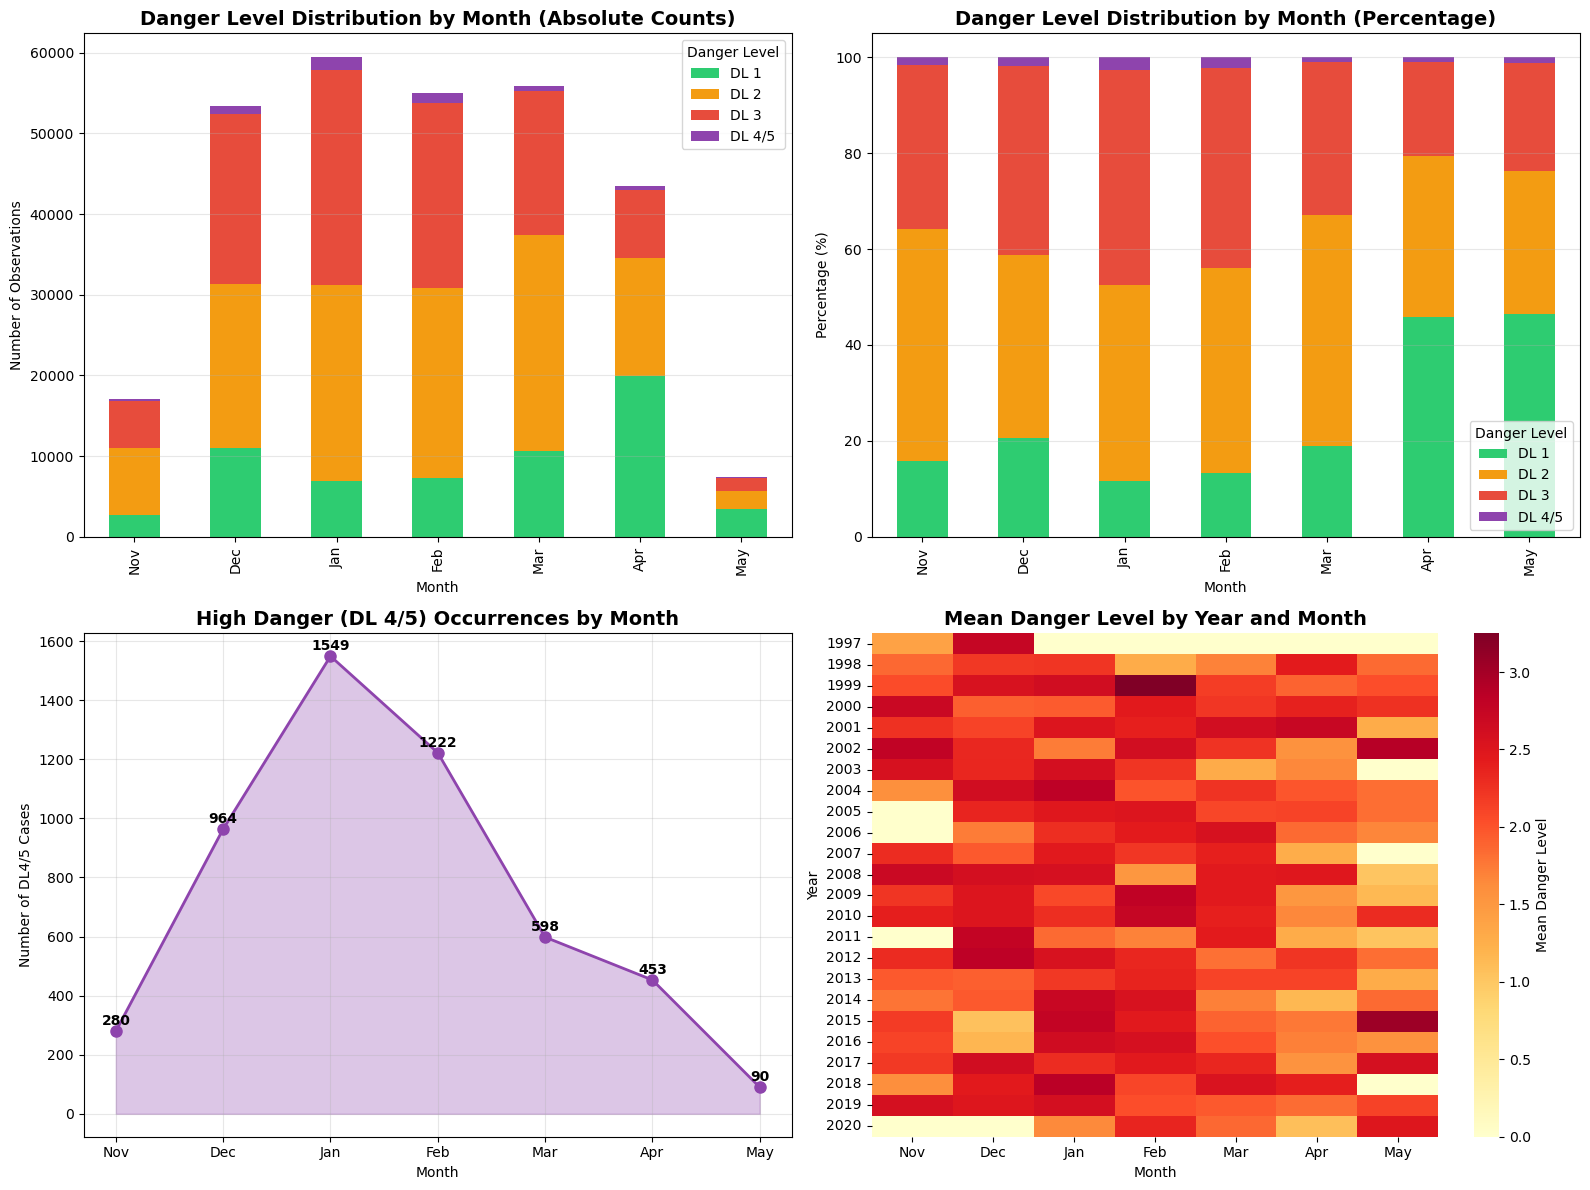

In [ ]:
# Monthly Danger Level Distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Absolute Counts
monthly_counts = avalanche_season.groupby(['month', 'dangerLevel']).size().unstack(fill_value=0)
month_names = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']
monthly_counts.index = monthly_counts.index.map({11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb', 
                                                   3: 'Mar', 4: 'Apr', 5: 'May'})
monthly_counts = monthly_counts.reindex(month_names)

monthly_counts.plot(kind='bar', stacked=True, ax=axes[0, 0], 
                    color=['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad'])
axes[0, 0].set_title('Danger Level Distribution by Month (Absolute Counts)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Number of Observations')
axes[0, 0].legend(title='Danger Level', labels=['DL 1', 'DL 2', 'DL 3', 'DL 4/5'])
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Percentages
monthly_pct = avalanche_season.groupby(['month', 'dangerLevel']).size().unstack(fill_value=0)
monthly_pct = monthly_pct.div(monthly_pct.sum(axis=1), axis=0) * 100
monthly_pct.index = monthly_pct.index.map({11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb', 
                                            3: 'Mar', 4: 'Apr', 5: 'May'})
monthly_pct = monthly_pct.reindex(month_names)

monthly_pct.plot(kind='bar', stacked=True, ax=axes[0, 1],
                 color=['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad'])
axes[0, 1].set_title('Danger Level Distribution by Month (Percentage)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Percentage (%)')
axes[0, 1].legend(title='Danger Level', labels=['DL 1', 'DL 2', 'DL 3', 'DL 4/5'])
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Line Plot - Danger Level 4 Ocurrences
dl4_by_month = avalanche_season[avalanche_season['dangerLevel'] == 4].groupby('month').size()
dl4_by_month.index = dl4_by_month.index.map({11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb', 
                                               3: 'Mar', 4: 'Apr', 5: 'May'})
dl4_by_month = dl4_by_month.reindex(month_names, fill_value=0)

axes[1, 0].plot(dl4_by_month.index, dl4_by_month.values, marker='o', 
                linewidth=2, markersize=8, color='#8e44ad')
axes[1, 0].fill_between(range(len(month_names)), dl4_by_month.values, alpha=0.3, color='#8e44ad')
axes[1, 0].set_title('High Danger (DL 4/5) Occurrences by Month', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Number of DL4/5 Cases')
axes[1, 0].grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate(dl4_by_month.values):
    axes[1, 0].text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')

# 4. Heatmap - Danger Level by month and year
yearly_monthly = avalanche_season.groupby(['year', 'month'])['dangerLevel'].mean().unstack(fill_value=0)
yearly_monthly.columns = yearly_monthly.columns.map({11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb', 
                                                       3: 'Mar', 4: 'Apr', 5: 'May'})
yearly_monthly = yearly_monthly[month_names]

sns.heatmap(yearly_monthly, cmap='YlOrRd', ax=axes[1, 1], cbar_kws={'label': 'Mean Danger Level'})
axes[1, 1].set_title('Mean Danger Level by Year and Month', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Year')

plt.tight_layout()
plt.show()

Based on the visualization provided, here's a brief analysis of the avalanche danger level distribution:

- Seasonal Peak: High danger levels (DL 4/5) peak significantly in January (1549 cases) and February (1222 cases), aligning with peak winter conditions. This confirms that any validation set must include these months to properly test a model's ability to predict high danger.

- Shoulder Seasons: November and May have very few high-danger cases, dominated instead by lower danger levels (DL 1/2). This suggests different meteorological drivers in early/late season compared to mid-winter.

- Yearly Variability: The heatmap (bottom right) shows clear inter-annual variability. Some years (e.g., 1999, 2018) had intense, prolonged high-danger periods (dark red), while others (e.g., 2011, 2020) were notably milder (lighter colors). A robust model will need to capture these broad seasonal trends.

- Dominant Classes: Throughout the core winter (Dec-Mar), Danger Level 3 (Considerable, red) and Danger Level 2 (Moderate, orange) consistently make up the vast majority of all forecasts, reinforcing the class imbalance challenge.

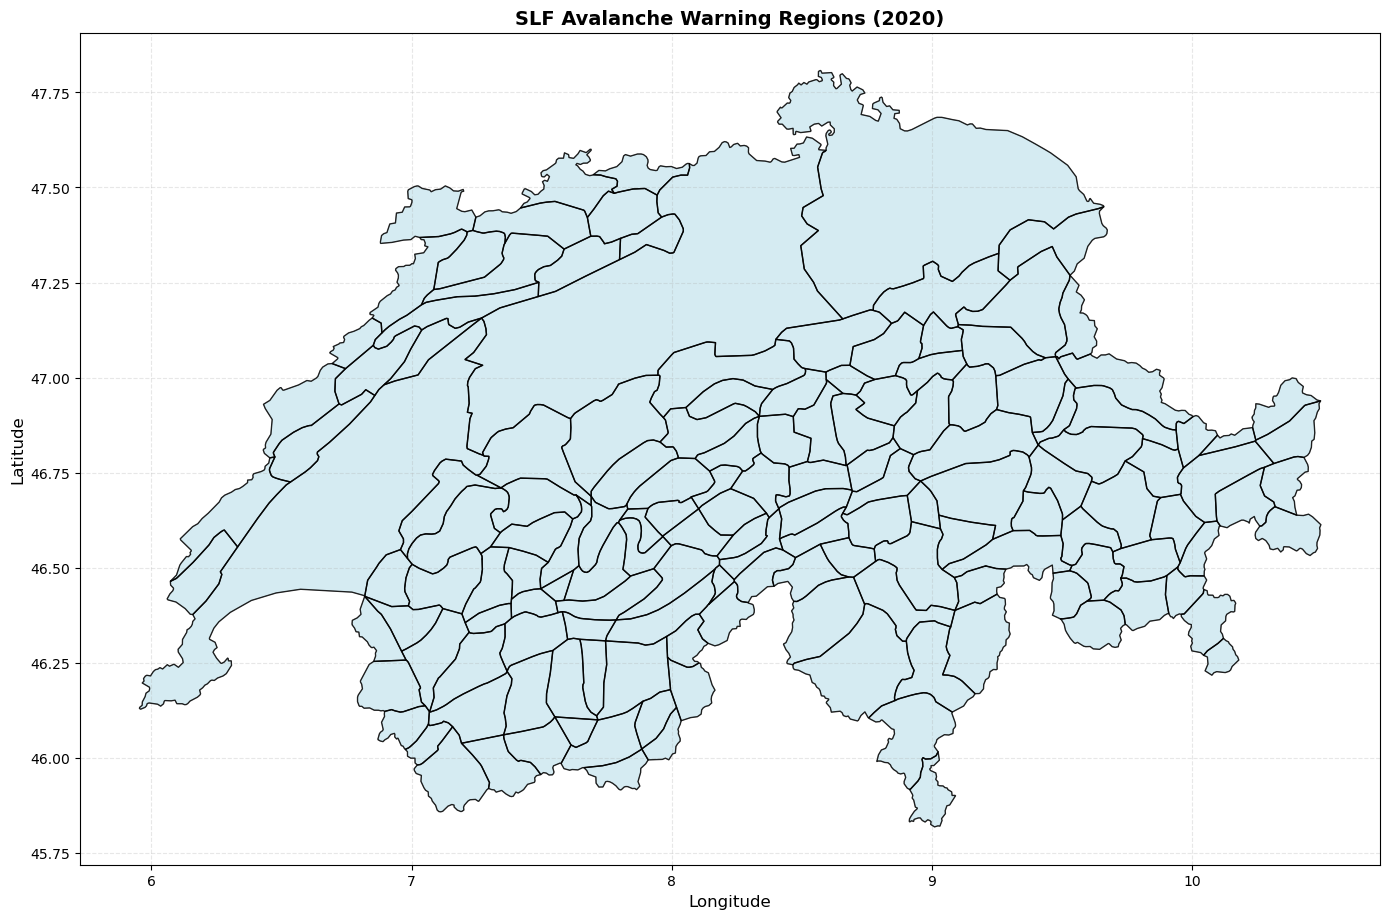


Total warning regions: 149


In [6]:
# Plot SLF warning region boundaries
slf_bounds = gpd.read_file('data/slf_boundaries_2020.json')

# Create the plot
fig, ax = plt.subplots(figsize=(14, 12))

# Plot boundaries
slf_bounds.boundary.plot(ax=ax, color='black', linewidth=1, alpha=0.8)
slf_bounds.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.5, alpha=0.5)
ax.set_title('SLF Avalanche Warning Regions (2020)', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Show summary statistics
print(f"\nTotal warning regions: {len(slf_bounds)}")

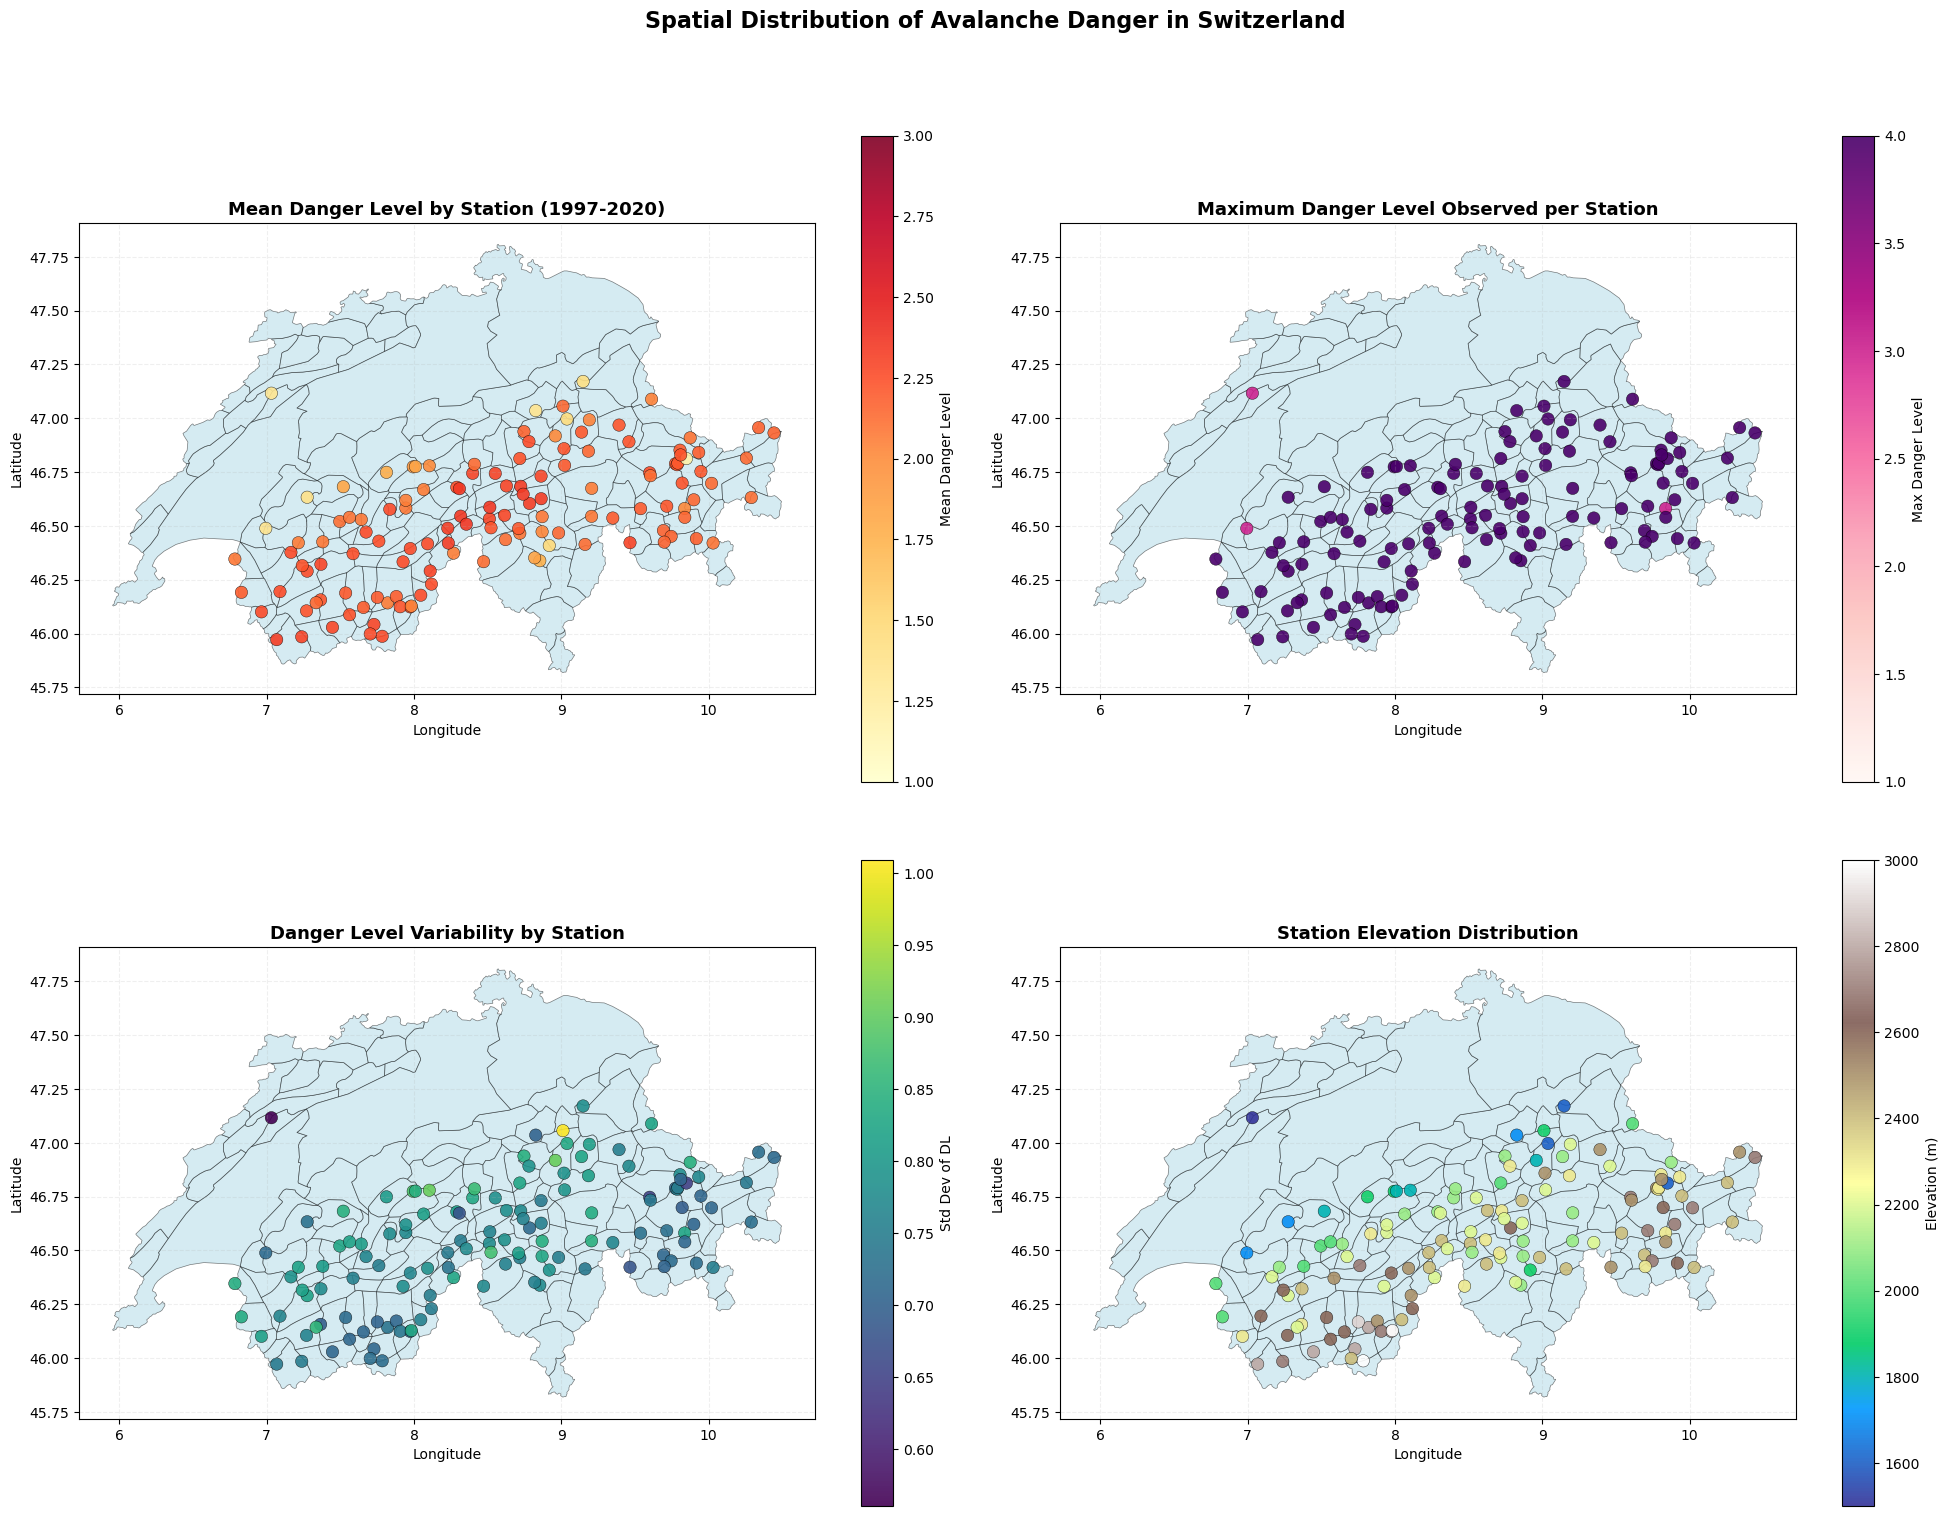

In [ ]:
# Station statistics
station_stats = imis_df.groupby('station_code').agg({
    'dangerLevel': ['mean', 'std', 'max', 'count'],
    'lon': 'first',
    'lat': 'first',
    'elevation_station': 'first',
    'warnreg': 'first'
}).reset_index()

station_stats.columns = ['station_code', 'mean_DL', 'std_DL', 'max_DL', 'n_obs', 
                          'lon', 'lat', 'elevation', 'warnreg']

# Spatial Distribution of Danger Levels
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Spatial Distribution of Avalanche Danger in Switzerland', 
             fontsize=16, fontweight='bold', y=0.995)

# 1. Mean Danger Level by Station
ax1 = axes[0, 0]
slf_bounds.plot(ax=ax1, color='lightblue', edgecolor='black', linewidth=0.5, alpha=0.5)
scatter1 = ax1.scatter(
    station_stats.lon, station_stats.lat,
    c=station_stats.mean_DL, cmap='YlOrRd',
    s=80, edgecolor='black', linewidth=0.3, alpha=0.9,
    vmin=1, vmax=3
)
plt.colorbar(scatter1, ax=ax1, shrink=0.8, label='Mean Danger Level')
ax1.set_title('Mean Danger Level by Station (1997-2020)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.grid(True, alpha=0.2, linestyle='--')

# 2. Maximum Danger Level by Station
ax2 = axes[0, 1]
slf_bounds.plot(ax=ax2, color='lightblue', edgecolor='black', linewidth=0.5, alpha=0.5)
scatter2 = ax2.scatter(
    station_stats.lon, station_stats.lat,
    c=station_stats.max_DL, cmap='RdPu',
    s=80, edgecolor='black', linewidth=0.3, alpha=0.9,
    vmin=1, vmax=4
)
plt.colorbar(scatter2, ax=ax2, shrink=0.8, label='Max Danger Level')
ax2.set_title('Maximum Danger Level Observed per Station', fontsize=13, fontweight='bold')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.grid(True, alpha=0.2, linestyle='--')

# 3. Danger Level Variability 
ax3 = axes[1, 0]
slf_bounds.plot(ax=ax3, color='lightblue', edgecolor='black', linewidth=0.5, alpha=0.5)
scatter3 = ax3.scatter(
    station_stats.lon, station_stats.lat,
    c=station_stats.std_DL, cmap='viridis',
    s=80, edgecolor='black', linewidth=0.3, alpha=0.9
)
plt.colorbar(scatter3, ax=ax3, shrink=0.8, label='Std Dev of DL')
ax3.set_title('Danger Level Variability by Station', fontsize=13, fontweight='bold')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.grid(True, alpha=0.2, linestyle='--')

# 4. Elevation-Coded Stations
ax4 = axes[1, 1]
slf_bounds.plot(ax=ax4, color='lightblue', edgecolor='black', linewidth=0.5, alpha=0.5)
scatter4 = ax4.scatter(
    station_stats.lon, station_stats.lat,
    c=station_stats.elevation, cmap='terrain',
    s=80, edgecolor='black', linewidth=0.3, alpha=0.9
)
plt.colorbar(scatter4, ax=ax4, shrink=0.8, label='Elevation (m)')
ax4.set_title('Station Elevation Distribution', fontsize=13, fontweight='bold')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
ax4.grid(True, alpha=0.2, linestyle='--')

plt.tight_layout()
plt.show()

# ...existing code for regional analysis...

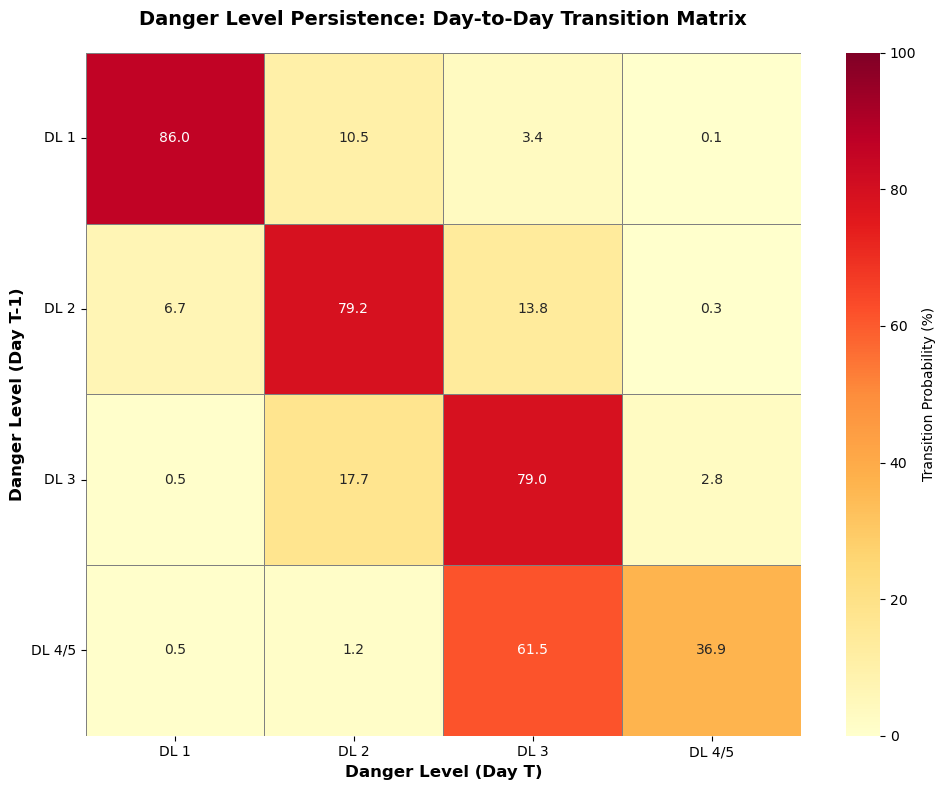

In [11]:
# Danger Level Persistence - Transition Matrix
avalanche_season_sorted = avalanche_season.sort_values(['station_code', 'datum']).copy()
avalanche_season_sorted['dangerLevel_prev'] = avalanche_season_sorted.groupby('station_code')['dangerLevel'].shift(1)
transitions = avalanche_season_sorted.dropna(subset=['dangerLevel_prev']).copy()

# Transition matrix calculation
transition_matrix = pd.crosstab(
    transitions['dangerLevel_prev'], 
    transitions['dangerLevel'],
    normalize='index'  
) * 100  

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    transition_matrix, 
    annot=True,  # Show percentages in cells
    fmt='.1f',   # One decimal place
    cmap='YlOrRd',
    cbar_kws={'label': 'Transition Probability (%)'},
    linewidths=0.5,
    linecolor='gray',
    vmin=0,
    vmax=100,
    ax=ax
)

ax.set_title('Danger Level Persistence: Day-to-Day Transition Matrix', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Danger Level (Day T)', fontsize=12, fontweight='bold')
ax.set_ylabel('Danger Level (Day T-1)', fontsize=12, fontweight='bold')
ax.set_xticklabels(['DL 1', 'DL 2', 'DL 3', 'DL 4/5'], rotation=0)
ax.set_yticklabels(['DL 1', 'DL 2', 'DL 3', 'DL 4/5'], rotation=0)

plt.tight_layout()
plt.show()


The transition matrix reveals that a naïve "persistence" model (predicting today's danger level is the same as yesterday's) achieves an overall accuracy of 79.8%.

While this baseline seems very high, the matrix also reveals its critical weakness:

Fails at High Danger: The model is least stable for DL 4/5, only persisting 36.9% of the time.

Fails to Stabilize: Most importantly, on the day after a DL 4/5 event, the danger level drops to DL 3 in 61.5% of cases. The naïve model will be wrong in all these high-risk stabilization scenarios.

Value Proposition: This baseline highlights that the "easy" 80% of days are not the problem. The challenge is to correctly predict the 20% of days when the danger level changes.

This aligns perfectly with the findings of Pérez-Guillén et al. (2022). They tested a Random Forest (RF 1*) that included the previous day's forecast as a feature. While its overall accuracy jumped to 82%, it failed catastrophically at predicting change:

Its accuracy dropped to 43% on days when the danger increased.

Its accuracy dropped to 29% on days when the danger decreased.

Conclusion: Our naïve baseline (79.8%) and their RF 1* (82%) are essentially the same "persistence" model. They are accurate on stable days but fail on critical transition days.

Therefore, the success of our RF and 3D CNN models should not be measured just by their ability to beat 79.8% overall, but by their significantly improved accuracy on "transition days", especially in predicting the onset and stabilization of high-danger events.

In [12]:
# Calculate Baseline Model Performance Metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix

print("\n" + "="*80)
print("NAÏVE PERSISTENCE BASELINE: Performance Metrics")
print("="*80)
print("\nModel: Predict today's danger level = yesterday's danger level")
print("-" * 80)

# Overall metrics
y_true = transitions['dangerLevel'].values
y_pred = transitions['dangerLevel_prev'].values

accuracy = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f"\n{'OVERALL METRICS':^80}")
print("-" * 80)
print(f"  Accuracy:                 {accuracy*100:6.2f}%")
print(f"  Balanced Accuracy:        {balanced_acc*100:6.2f}%")
print(f"  F1-Score (Macro):         {f1_macro:6.3f}")
print(f"  F1-Score (Weighted):      {f1_weighted:6.3f}")

# Per-class metrics
print(f"\n{'PER-CLASS METRICS':^80}")
print("-" * 80)
print(f"{'Danger Level':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 80)

for dl in [1, 2, 3, 4]:
    # Calculate metrics for this class
    y_true_binary = (y_true == dl).astype(int)
    y_pred_binary = (y_pred == dl).astype(int)
    
    precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
    recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
    support = y_true_binary.sum()
    
    print(f"DL {dl:<12} {precision:>10.3f}  {recall:>10.3f}  {f1:>10.3f}  {support:>8,}")

# Confusion Matrix
print(f"\n{'CONFUSION MATRIX (Normalized by True Label)':^80}")
print("-" * 80)
cm = confusion_matrix(y_true, y_pred, labels=[1, 2, 3, 4])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

print(f"{'':>15} {'Predicted →':<50}")
print(f"{'True ↓':<15} {'DL 1':>12} {'DL 2':>12} {'DL 3':>12} {'DL 4/5':>12}")
print("-" * 80)
for i, dl in enumerate([1, 2, 3, 4]):
    row_str = f"DL {dl:<12}"
    for j in range(4):
        row_str += f"{cm_normalized[i, j]:>11.1f}% "
    print(row_str)

# Critical insights
print("\n" + "="*80)
print("KEY INSIGHTS FOR MODEL BENCHMARKING")
print("="*80)

# Calculate transition accuracy
stable_days = (y_true == y_pred).sum()
total_days = len(y_true)
transition_days = total_days - stable_days

print(f"\n  Stable Days (DL unchanged):     {stable_days:>6,} ({stable_days/total_days*100:5.1f}%)")
print(f"  Transition Days (DL changed):   {transition_days:>6,} ({transition_days/total_days*100:5.1f}%)")

# Accuracy on transition days (always 0% for naive model)
print(f"\n  Accuracy on Stable Days:        100.0%")
print(f"  Accuracy on Transition Days:      0.0%")

# Most common mistakes
mistakes = transitions[y_true != y_pred].copy()
if len(mistakes) > 0:
    print(f"\n  Most Common Prediction Errors:")
    error_counts = mistakes.groupby(['dangerLevel_prev', 'dangerLevel']).size().sort_values(ascending=False)
    for (prev_dl, actual_dl), count in error_counts.head(5).items():
        pct = count / len(mistakes) * 100
        print(f"    • Predicted DL {int(prev_dl)}, Actually DL {int(actual_dl)}:  {count:>5,} cases ({pct:4.1f}%)")

print("\n" + "="*80)
print("BENCHMARK TARGET FOR RF & CNN MODELS")
print("="*80)
print(f"  ✓ Must exceed {accuracy*100:.1f}% overall accuracy")
print(f"  ✓ Must achieve >0% accuracy on transition days")
print(f"  ✓ Must improve recall on DL 4/5 (currently {recall_score((y_true==4).astype(int), (y_pred==4).astype(int), zero_division=0)*100:.1f}%)")
print("="*80 + "\n")


NAÏVE PERSISTENCE BASELINE: Performance Metrics

Model: Predict today's danger level = yesterday's danger level
--------------------------------------------------------------------------------

                                OVERALL METRICS                                 
--------------------------------------------------------------------------------
  Accuracy:                  79.81%
  Balanced Accuracy:         70.26%
  F1-Score (Macro):          0.703
  F1-Score (Weighted):       0.798

                               PER-CLASS METRICS                                
--------------------------------------------------------------------------------
Danger Level    Precision    Recall       F1-Score     Support   
--------------------------------------------------------------------------------
DL 1                 0.860       0.860       0.860    61,684
DL 2                 0.792       0.792       0.792   120,348
DL 3                 0.790       0.790       0.790   104,328
DL 4    

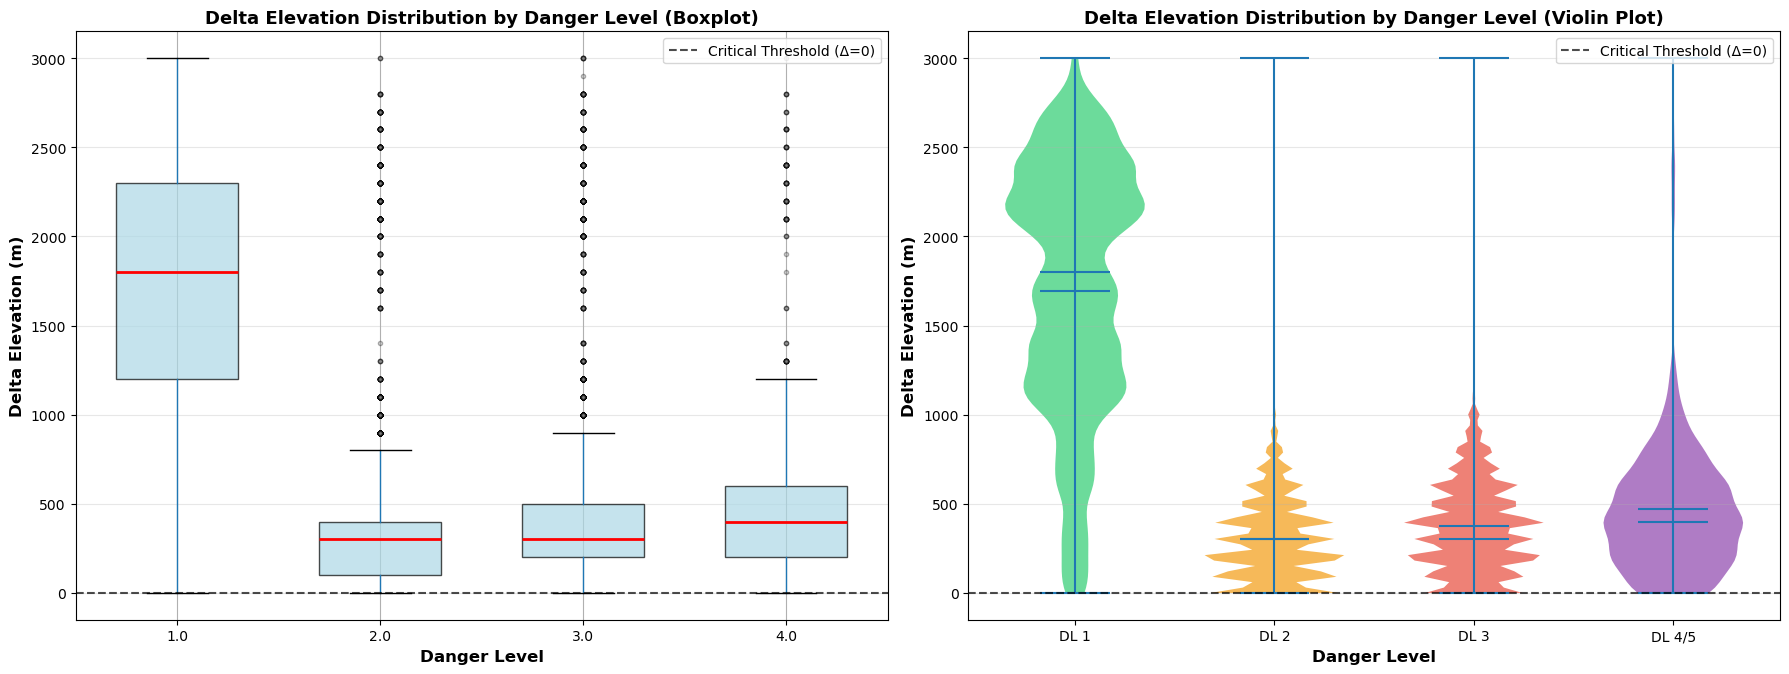


DELTA ELEVATION VALIDATION: Label Quality Check

Median Delta Elevation by Danger Level:
----------------------------------------------------------------------
  DL 1: Median = +1800.0m  |  Above threshold:  98.8%  |  Below:   0.0%
  DL 2: Median = +300.0m  |  Above threshold:  85.3%  |  Below:   0.0%
  DL 3: Median = +300.0m  |  Above threshold:  89.4%  |  Below:   0.0%
  DL 4: Median = +400.0m  |  Above threshold:  92.0%  |  Below:   0.0%

----------------------------------------------------------------------
INTERPRETATION:
----------------------------------------------------------------------
✓ Positive Δ-elevation = Station ABOVE critical elevation (higher danger)
✓ Negative Δ-elevation = Station BELOW critical elevation (safer)

Expected Pattern:
  • DL 1/2: Mixed (both positive and negative values)
  • DL 3/4: Predominantly POSITIVE (stations in danger zone)

Label Noise Detection:
  ✓ No significant label noise detected



In [9]:
# Target Label Quality - Delta Elevation by Danger Level
# Check if delta_elevation exists in the dataset
if 'delta_elevation' in avalanche_season.columns:
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle('Target Label Quality: Delta Elevation by Danger Level', 
                 fontsize=16, fontweight='bold', y=1.02)
    
    # 1. Boxplot
    ax1 = axes[0]
    avalanche_season.boxplot(column='delta_elevation', by='dangerLevel', ax=ax1,
                              patch_artist=True, widths=0.6,
                              boxprops=dict(facecolor='lightblue', alpha=0.7),
                              medianprops=dict(color='red', linewidth=2),
                              flierprops=dict(marker='o', markerfacecolor='gray', 
                                            markersize=3, alpha=0.3))
    ax1.set_title('Delta Elevation Distribution by Danger Level (Boxplot)', 
                  fontsize=13, fontweight='bold')
    ax1.set_xlabel('Danger Level', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Delta Elevation (m)', fontsize=12, fontweight='bold')
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7, 
                label='Critical Threshold (Δ=0)')
    ax1.grid(axis='y', alpha=0.3)
    ax1.legend(loc='upper right')
    plt.suptitle('')  # Remove automatic title from boxplot
    
    # 2. Violin Plot
    ax2 = axes[1]
    parts = ax2.violinplot([avalanche_season[avalanche_season['dangerLevel'] == dl]['delta_elevation'].dropna() 
                            for dl in [1, 2, 3, 4]],
                           positions=[1, 2, 3, 4],
                           widths=0.7,
                           showmeans=True,
                           showmedians=True)
    
    # Color the violins by danger level
    colors = ['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad']
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.7)
    
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7,
                label='Critical Threshold (Δ=0)')
    ax2.set_title('Delta Elevation Distribution by Danger Level (Violin Plot)', 
                  fontsize=13, fontweight='bold')
    ax2.set_xlabel('Danger Level', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Delta Elevation (m)', fontsize=12, fontweight='bold')
    ax2.set_xticks([1, 2, 3, 4])
    ax2.set_xticklabels(['DL 1', 'DL 2', 'DL 3', 'DL 4/5'])
    ax2.grid(axis='y', alpha=0.3)
    ax2.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display statistics
    print("\n" + "="*70)
    print("DELTA ELEVATION VALIDATION: Label Quality Check")
    print("="*70)
    print("\nMedian Delta Elevation by Danger Level:")
    print("-" * 70)
    
    for dl in [1, 2, 3, 4]:
        delta_vals = avalanche_season[avalanche_season['dangerLevel'] == dl]['delta_elevation'].dropna()
        median_delta = delta_vals.median()
        pct_positive = (delta_vals > 0).mean() * 100
        pct_negative = (delta_vals < 0).mean() * 100
        
        print(f"  DL {dl}: Median = {median_delta:+6.1f}m  |  "
              f"Above threshold: {pct_positive:5.1f}%  |  Below: {pct_negative:5.1f}%")
    
    print("\n" + "-" * 70)
    print("INTERPRETATION:")
    print("-" * 70)
    print("✓ Positive Δ-elevation = Station ABOVE critical elevation (higher danger)")
    print("✓ Negative Δ-elevation = Station BELOW critical elevation (safer)")
    print("\nExpected Pattern:")
    print("  • DL 1/2: Mixed (both positive and negative values)")
    print("  • DL 3/4: Predominantly POSITIVE (stations in danger zone)")
    print("\nLabel Noise Detection:")
    
    # Check for suspicious cases
    dl4_negative = avalanche_season[(avalanche_season['dangerLevel'] == 4) & 
                                     (avalanche_season['delta_elevation'] < -200)]
    if len(dl4_negative) > 0:
        pct_noise = (len(dl4_negative) / len(avalanche_season[avalanche_season['dangerLevel'] == 4])) * 100
        print(f"  ⚠️ Warning: {len(dl4_negative)} DL4 cases ({pct_noise:.1f}%) have Δ < -200m")
        print(f"     → Possible label noise (low-elevation stations incorrectly labeled)")
    else:
        print("  ✓ No significant label noise detected")
    
    print("="*70 + "\n")
    
else:
    print("⚠️ Warning: 'delta_elevation' column not found in the dataset.")
    print("This feature should be created during preprocessing as:")
    print("delta_elevation = elevation_station - critical_elevation_from_region")

### **2.2 Meteorological Drivers of Instability**
The "Big Drivers" Boxplots: Create boxplots of key meteorological variables grouped by dangerLevel.

HN72_24 (3-day new snow): Should show a very strong positive correlation with DL.

VW (Wind): Should be higher for DL3/4 (drifting snow problem).

TA (Air Temp): Might show a complex relationship (danger can be high when very cold or very warm).

Stability Index Validation: Boxplots of your imputed stability indices (Sn, ccl_pwl, etc.) by dangerLevel.

Expectation: These should decrease as danger increases.

Sanity Check: Do the imputed values (6.0 or 4.0) correctly cluster in DL1/DL2?

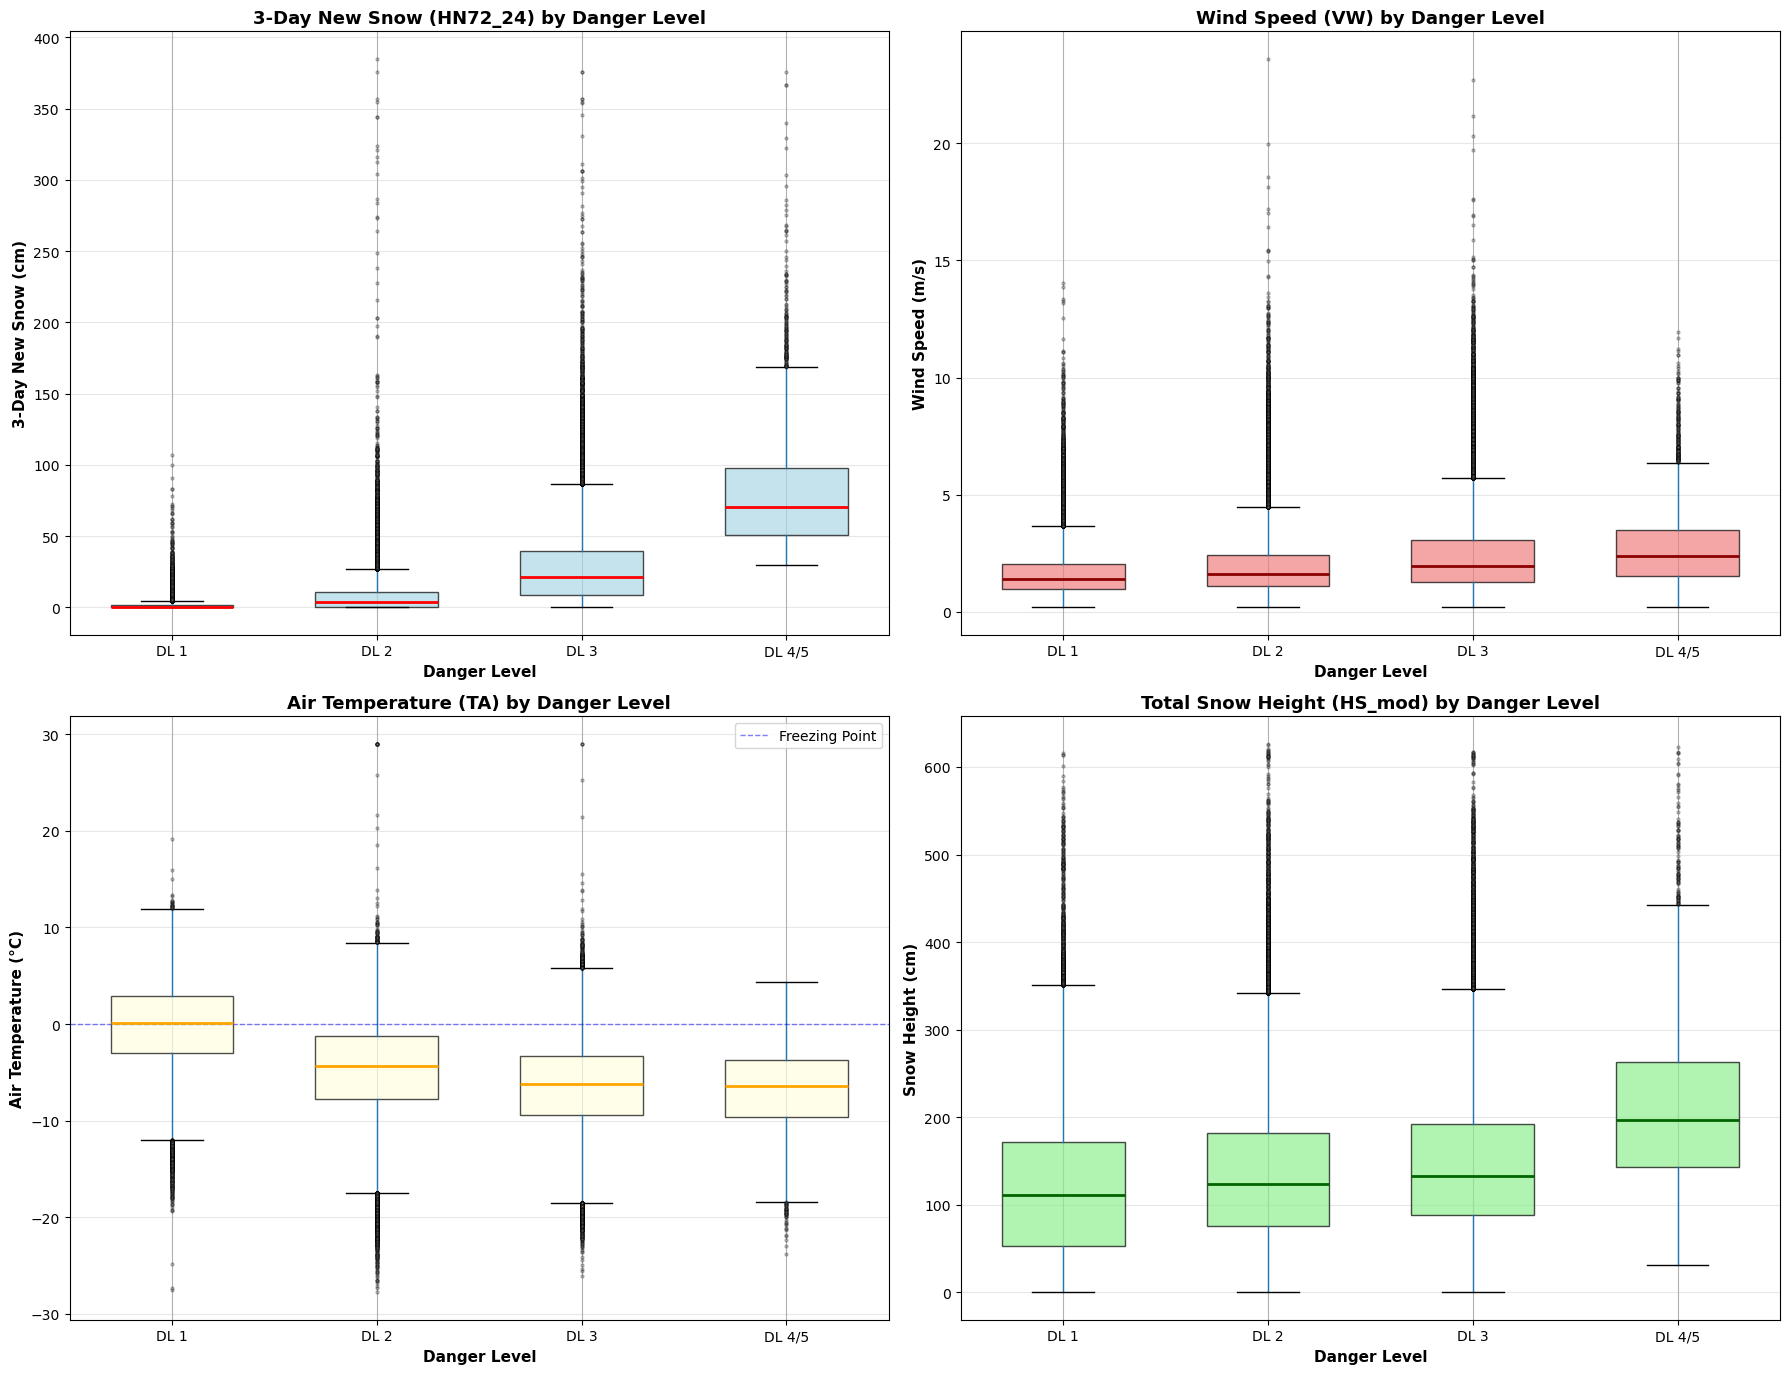


METEOROLOGICAL DRIVERS: Summary Statistics by Danger Level

HN72_24:
--------------------------------------------------------------------------------
             mean       50%        std
DL 1     1.551371   0.00000   3.738057
DL 2     7.648137   3.50225  11.771993
DL 3    28.044311  21.17750  26.678488
DL 4/5  79.181368  70.41475  39.433647

VW:
--------------------------------------------------------------------------------
            mean     50%       std
DL 1    1.657356  1.4125  1.057204
DL 2    1.976335  1.6250  1.349255
DL 3    2.403315  1.9625  1.636814
DL 4/5  2.743095  2.3875  1.696554

TA:
--------------------------------------------------------------------------------
            mean     50%       std
DL 1   -0.187988  0.1000  4.484921
DL 2   -4.726089 -4.3375  4.927752
DL 3   -6.460894 -6.2500  4.541581
DL 4/5 -6.888293 -6.4125  4.314793

HS_mod:
--------------------------------------------------------------------------------
              mean         50%        std


In [13]:
# Meteorological Drivers - Key Variables by Danger Level
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Meteorological Drivers of Avalanche Instability', 
             fontsize=16, fontweight='bold', y=0.995)

# 1. 3-Day New Snow (HN72_24)
ax1 = axes[0, 0]
avalanche_season.boxplot(column='HN72_24', by='dangerLevel', ax=ax1,
                          patch_artist=True, widths=0.6,
                          boxprops=dict(facecolor='lightblue', alpha=0.7),
                          medianprops=dict(color='red', linewidth=2),
                          flierprops=dict(marker='o', markerfacecolor='gray', 
                                        markersize=2, alpha=0.3))
ax1.set_title('3-Day New Snow (HN72_24) by Danger Level', 
              fontsize=13, fontweight='bold')
ax1.set_xlabel('Danger Level', fontsize=11, fontweight='bold')
ax1.set_ylabel('3-Day New Snow (cm)', fontsize=11, fontweight='bold')
ax1.set_xticklabels(['DL 1', 'DL 2', 'DL 3', 'DL 4/5'])
ax1.grid(axis='y', alpha=0.3)
plt.suptitle('')

# 2. Wind Speed (VW)
ax2 = axes[0, 1]
avalanche_season.boxplot(column='VW', by='dangerLevel', ax=ax2,
                          patch_artist=True, widths=0.6,
                          boxprops=dict(facecolor='lightcoral', alpha=0.7),
                          medianprops=dict(color='darkred', linewidth=2),
                          flierprops=dict(marker='o', markerfacecolor='gray', 
                                        markersize=2, alpha=0.3))
ax2.set_title('Wind Speed (VW) by Danger Level', 
              fontsize=13, fontweight='bold')
ax2.set_xlabel('Danger Level', fontsize=11, fontweight='bold')
ax2.set_ylabel('Wind Speed (m/s)', fontsize=11, fontweight='bold')
ax2.set_xticklabels(['DL 1', 'DL 2', 'DL 3', 'DL 4/5'])
ax2.grid(axis='y', alpha=0.3)
plt.suptitle('')

# 3. Air Temperature (TA)
ax3 = axes[1, 0]
avalanche_season.boxplot(column='TA', by='dangerLevel', ax=ax3,
                          patch_artist=True, widths=0.6,
                          boxprops=dict(facecolor='lightyellow', alpha=0.7),
                          medianprops=dict(color='orange', linewidth=2),
                          flierprops=dict(marker='o', markerfacecolor='gray', 
                                        markersize=2, alpha=0.3))
ax3.set_title('Air Temperature (TA) by Danger Level', 
              fontsize=13, fontweight='bold')
ax3.set_xlabel('Danger Level', fontsize=11, fontweight='bold')
ax3.set_ylabel('Air Temperature (°C)', fontsize=11, fontweight='bold')
ax3.set_xticklabels(['DL 1', 'DL 2', 'DL 3', 'DL 4/5'])
ax3.axhline(y=0, color='blue', linestyle='--', linewidth=1, alpha=0.5, label='Freezing Point')
ax3.grid(axis='y', alpha=0.3)
ax3.legend(loc='upper right')
plt.suptitle('')

# 4. Total Snow Height (HS_mod)
ax4 = axes[1, 1]
avalanche_season.boxplot(column='HS_mod', by='dangerLevel', ax=ax4,
                          patch_artist=True, widths=0.6,
                          boxprops=dict(facecolor='lightgreen', alpha=0.7),
                          medianprops=dict(color='darkgreen', linewidth=2),
                          flierprops=dict(marker='o', markerfacecolor='gray', 
                                        markersize=2, alpha=0.3))
ax4.set_title('Total Snow Height (HS_mod) by Danger Level', 
              fontsize=13, fontweight='bold')
ax4.set_xlabel('Danger Level', fontsize=11, fontweight='bold')
ax4.set_ylabel('Snow Height (cm)', fontsize=11, fontweight='bold')
ax4.set_xticklabels(['DL 1', 'DL 2', 'DL 3', 'DL 4/5'])
ax4.grid(axis='y', alpha=0.3)
plt.suptitle('')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("METEOROLOGICAL DRIVERS: Summary Statistics by Danger Level")
print("="*80)

for var in ['HN72_24', 'VW', 'TA', 'HS_mod']:
    print(f"\n{var}:")
    print("-" * 80)
    stats = avalanche_season.groupby('dangerLevel')[var].describe()[['mean', '50%', 'std']]
    stats.index = ['DL 1', 'DL 2', 'DL 3', 'DL 4/5']
    print(stats.to_string())

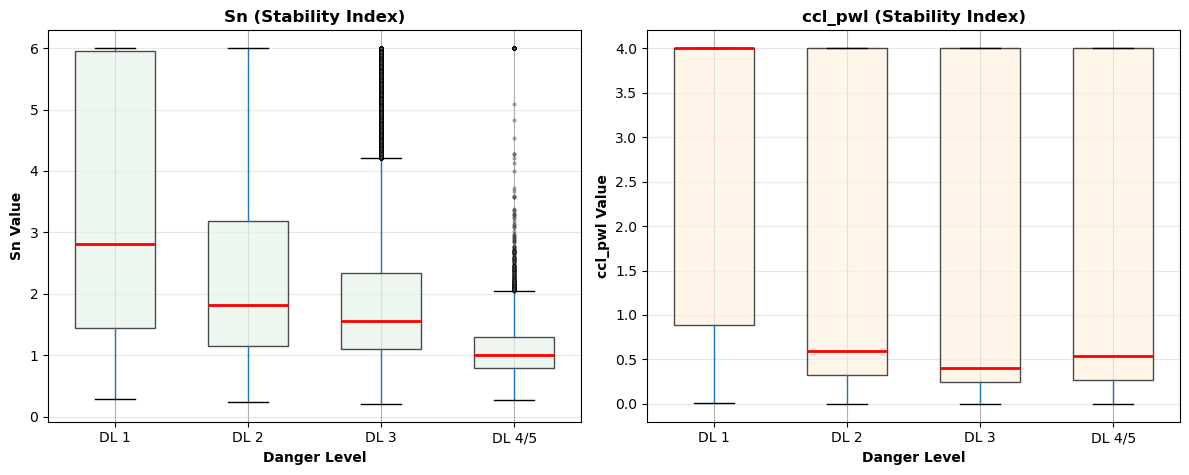


STABILITY INDICES: Summary Statistics by Danger Level

Sn:
--------------------------------------------------------------------------------
            mean       50%       std     count
DL 1    3.281880  2.810500  1.979595   61721.0
DL 2    2.410145  1.821750  1.660938  120407.0
DL 3    1.979539  1.551625  1.335489  104356.0
DL 4/5  1.123544  1.006188  0.605678    5156.0

Imputed values:
  • Value 6.0: 32,077 cases ( 11.0%)
  • Value 4.0:      0 cases (  0.0%)

Imputed values by Danger Level:
  DL 1: 6.0=15219 (24.7%), 4.0=    0 ( 0.0%)
  DL 2: 6.0=11829 ( 9.8%), 4.0=    0 ( 0.0%)
  DL 3: 6.0= 4996 ( 4.8%), 4.0=    0 ( 0.0%)
  DL 4: 6.0=   33 ( 0.6%), 4.0=    0 ( 0.0%)

ccl_pwl:
--------------------------------------------------------------------------------
            mean   50%       std     count
DL 1    2.829080  4.00  1.549308   61721.0
DL 2    1.614263  0.59  1.639014  120407.0
DL 3    1.395133  0.40  1.641737  104356.0
DL 4/5  1.908410  0.54  1.820561    5156.0

Imputed value

In [14]:
# Stability Indices Validation
# Check which stability indices exist in the dataset
stability_indices = ['Sn', 'ccl_pwl', 'ccl_df', 'ccl_fc', 'ccl_dh']
available_indices = [idx for idx in stability_indices if idx in avalanche_season.columns]

if len(available_indices) > 0:
    # Create subplots for available indices
    n_plots = len(available_indices)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    fig.suptitle('Stability Indices by Danger Level', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    if n_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    colors = ['#e8f5e9', '#fff3e0', '#fce4ec', '#e3f2fd', '#f3e5f5']
    
    for i, idx in enumerate(available_indices):
        ax = axes[i]
        avalanche_season.boxplot(column=idx, by='dangerLevel', ax=ax,
                                  patch_artist=True, widths=0.6,
                                  boxprops=dict(facecolor=colors[i % len(colors)], alpha=0.7),
                                  medianprops=dict(color='red', linewidth=2),
                                  flierprops=dict(marker='o', markerfacecolor='gray', 
                                                markersize=2, alpha=0.3))
        ax.set_title(f'{idx} (Stability Index)', fontsize=12, fontweight='bold')
        ax.set_xlabel('Danger Level', fontsize=10, fontweight='bold')
        ax.set_ylabel(f'{idx} Value', fontsize=10, fontweight='bold')
        ax.set_xticklabels(['DL 1', 'DL 2', 'DL 3', 'DL 4/5'])
        ax.grid(axis='y', alpha=0.3)
        plt.suptitle('')
    
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\n" + "="*80)
    print("STABILITY INDICES: Summary Statistics by Danger Level")
    print("="*80)
    
    for idx in available_indices:
        print(f"\n{idx}:")
        print("-" * 80)
        stats = avalanche_season.groupby('dangerLevel')[idx].describe()[['mean', '50%', 'std', 'count']]
        stats.index = ['DL 1', 'DL 2', 'DL 3', 'DL 4/5']
        print(stats.to_string())
        
        # Check for imputed values
        imputed_6 = (avalanche_season[idx] == 6.0).sum()
        imputed_4 = (avalanche_season[idx] == 4.0).sum()
        total = len(avalanche_season[idx].dropna())
        
        if imputed_6 > 0 or imputed_4 > 0:
            print(f"\nImputed values:")
            print(f"  • Value 6.0: {imputed_6:>6,} cases ({imputed_6/total*100:5.1f}%)")
            print(f"  • Value 4.0: {imputed_4:>6,} cases ({imputed_4/total*100:5.1f}%)")
            
            # Check distribution by danger level
            print(f"\nImputed values by Danger Level:")
            for dl in [1, 2, 3, 4]:
                dl_data = avalanche_season[avalanche_season['dangerLevel'] == dl][idx]
                imputed_6_dl = (dl_data == 6.0).sum()
                imputed_4_dl = (dl_data == 4.0).sum()
                total_dl = len(dl_data.dropna())
                if total_dl > 0:
                    print(f"  DL {dl}: 6.0={imputed_6_dl:>5} ({imputed_6_dl/total_dl*100:4.1f}%), "
                          f"4.0={imputed_4_dl:>5} ({imputed_4_dl/total_dl*100:4.1f}%)")
    
    print("\n" + "="*80)
    print("INTERPRETATION:")
    print("="*80)
    print("✓ Stability indices should DECREASE as danger level increases")
    print("✓ Imputed values (6.0, 4.0) should predominantly cluster in DL 1/2")
    print("✓ Lower values indicate weaker snowpack (higher instability)")
    print("="*80 + "\n")
    
else:
    print("⚠️ Warning: No stability indices found in the dataset.")
    print(f"Expected columns: {stability_indices}")
    print(f"Available columns: {avalanche_season.columns.tolist()}")

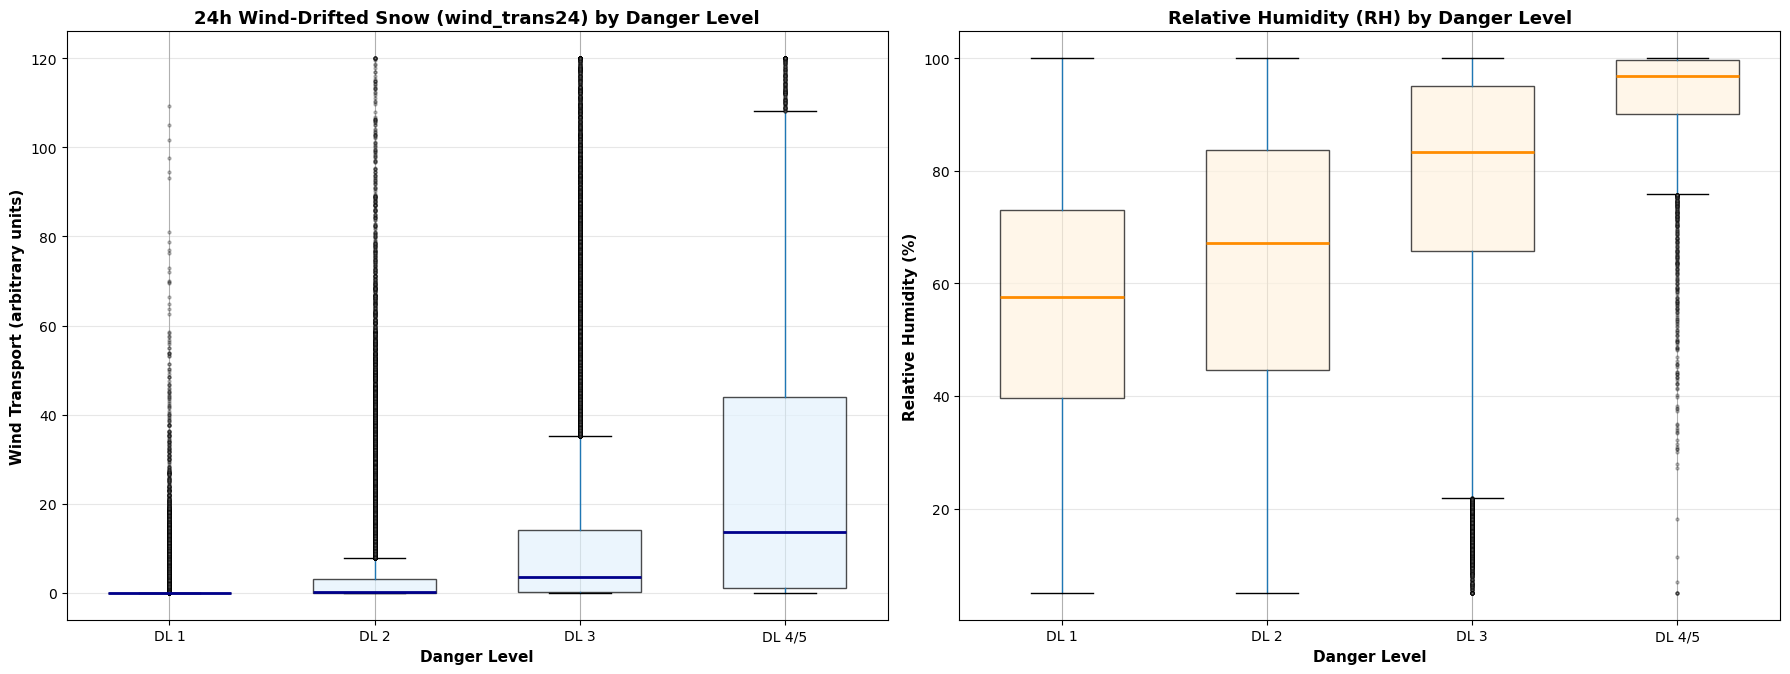


ADDITIONAL KEY DRIVERS: Summary Statistics by Danger Level
(Top predictors identified in Pérez-Guillén et al. 2022)

wind_trans24:
--------------------------------------------------------------------------------
             mean        50%        std
DL 1     0.647551   0.000000   3.104324
DL 2     3.544566   0.193500   8.516476
DL 3    11.189268   3.502500  18.149852
DL 4/5  28.396245  13.653625  34.392290

RH:
--------------------------------------------------------------------------------
             mean        50%        std
DL 1    56.594390  57.625000  21.977709
DL 2    63.575028  67.083333  24.066153
DL 3    77.483611  83.250000  21.056343
DL 4/5  92.809127  96.818750  10.515633

EXPECTED PATTERNS:
✓ wind_trans24: Should INCREASE with danger level
  → Combines wind + new snow into a 'loading' metric
  → Top-10 predictor in RF model (Pérez-Guillén et al. 2022)

✓ RH (Relative Humidity): May show complex patterns
  → Very LOW RH: Clear nights → surface hoar formation
  → Very 

In [15]:
# Additional Key Meteorological Drivers (Top Features from Pérez-Guillén et al. 2022)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Additional Key Meteorological Drivers (Top Predictors)', 
             fontsize=16, fontweight='bold', y=1.00)

# 1. Wind-Drifted Snow (wind_trans24)
if 'wind_trans24' in avalanche_season.columns:
    ax1 = axes[0]
    avalanche_season.boxplot(column='wind_trans24', by='dangerLevel', ax=ax1,
                              patch_artist=True, widths=0.6,
                              boxprops=dict(facecolor='#e3f2fd', alpha=0.7),
                              medianprops=dict(color='darkblue', linewidth=2),
                              flierprops=dict(marker='o', markerfacecolor='gray', 
                                            markersize=2, alpha=0.3))
    ax1.set_title('24h Wind-Drifted Snow (wind_trans24) by Danger Level', 
                  fontsize=13, fontweight='bold')
    ax1.set_xlabel('Danger Level', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Wind Transport (arbitrary units)', fontsize=11, fontweight='bold')
    ax1.set_xticklabels(['DL 1', 'DL 2', 'DL 3', 'DL 4/5'])
    ax1.grid(axis='y', alpha=0.3)
    plt.suptitle('')
else:
    axes[0].text(0.5, 0.5, '⚠️ wind_trans24 not found in dataset', 
                 ha='center', va='center', fontsize=14, color='red')
    axes[0].set_xticks([])
    axes[0].set_yticks([])

# 2. Relative Humidity (RH)
if 'RH' in avalanche_season.columns:
    ax2 = axes[1]
    avalanche_season.boxplot(column='RH', by='dangerLevel', ax=ax2,
                              patch_artist=True, widths=0.6,
                              boxprops=dict(facecolor='#fff3e0', alpha=0.7),
                              medianprops=dict(color='darkorange', linewidth=2),
                              flierprops=dict(marker='o', markerfacecolor='gray', 
                                            markersize=2, alpha=0.3))
    ax2.set_title('Relative Humidity (RH) by Danger Level', 
                  fontsize=13, fontweight='bold')
    ax2.set_xlabel('Danger Level', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Relative Humidity (%)', fontsize=11, fontweight='bold')
    ax2.set_xticklabels(['DL 1', 'DL 2', 'DL 3', 'DL 4/5'])
    ax2.grid(axis='y', alpha=0.3)
    plt.suptitle('')
else:
    axes[1].text(0.5, 0.5, '⚠️ RH not found in dataset', 
                 ha='center', va='center', fontsize=14, color='red')
    axes[1].set_xticks([])
    axes[1].set_yticks([])

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("ADDITIONAL KEY DRIVERS: Summary Statistics by Danger Level")
print("="*80)
print("(Top predictors identified in Pérez-Guillén et al. 2022)")
print("="*80)

available_vars = []
if 'wind_trans24' in avalanche_season.columns:
    available_vars.append('wind_trans24')
if 'RH' in avalanche_season.columns:
    available_vars.append('RH')

if len(available_vars) > 0:
    for var in available_vars:
        print(f"\n{var}:")
        print("-" * 80)
        stats = avalanche_season.groupby('dangerLevel')[var].describe()[['mean', '50%', 'std']]
        stats.index = ['DL 1', 'DL 2', 'DL 3', 'DL 4/5']
        print(stats.to_string())
    
    print("\n" + "="*80)
    print("EXPECTED PATTERNS:")
    print("="*80)
    if 'wind_trans24' in available_vars:
        print("✓ wind_trans24: Should INCREASE with danger level")
        print("  → Combines wind + new snow into a 'loading' metric")
        print("  → Top-10 predictor in RF model (Pérez-Guillén et al. 2022)")
    
    if 'RH' in available_vars:
        print("\n✓ RH (Relative Humidity): May show complex patterns")
        print("  → Very LOW RH: Clear nights → surface hoar formation")
        print("  → Very HIGH RH: Fog/rime or wet snow instability")
        print("  → Top-ranked predictor in RF model (Pérez-Guillén et al. 2022)")
    
    print("="*80 + "\n")
else:
    print("\n⚠️ Neither wind_trans24 nor RH found in the dataset.")
    print("These are critical features identified as top predictors.")
    print("Consider adding them in preprocessing if source data is available.")
    print("="*80 + "\n")

### **2.3 Spatial Dependencies & Patterns**

This is unique to your project. You need to prove that spatial context matters.

Elevation Dependency: Scatter plot (or 2D histogram) of elevation_station vs. dangerLevel.

Goal: Confirm that higher elevations generally see higher danger.

The delta_elevation check: Boxplot of your new delta_elevation feature by dangerLevel.

Expectation: DL3 and DL4 should have mostly positive delta_elevation values. DL1 should be mixed.

Spatial Autocorrelation (Visual): Plot the station values for a single high-danger day on a map.

Why? Do you see clusters of red (DL4)? Or is it random noise? A CNN relies on these clusters existing.

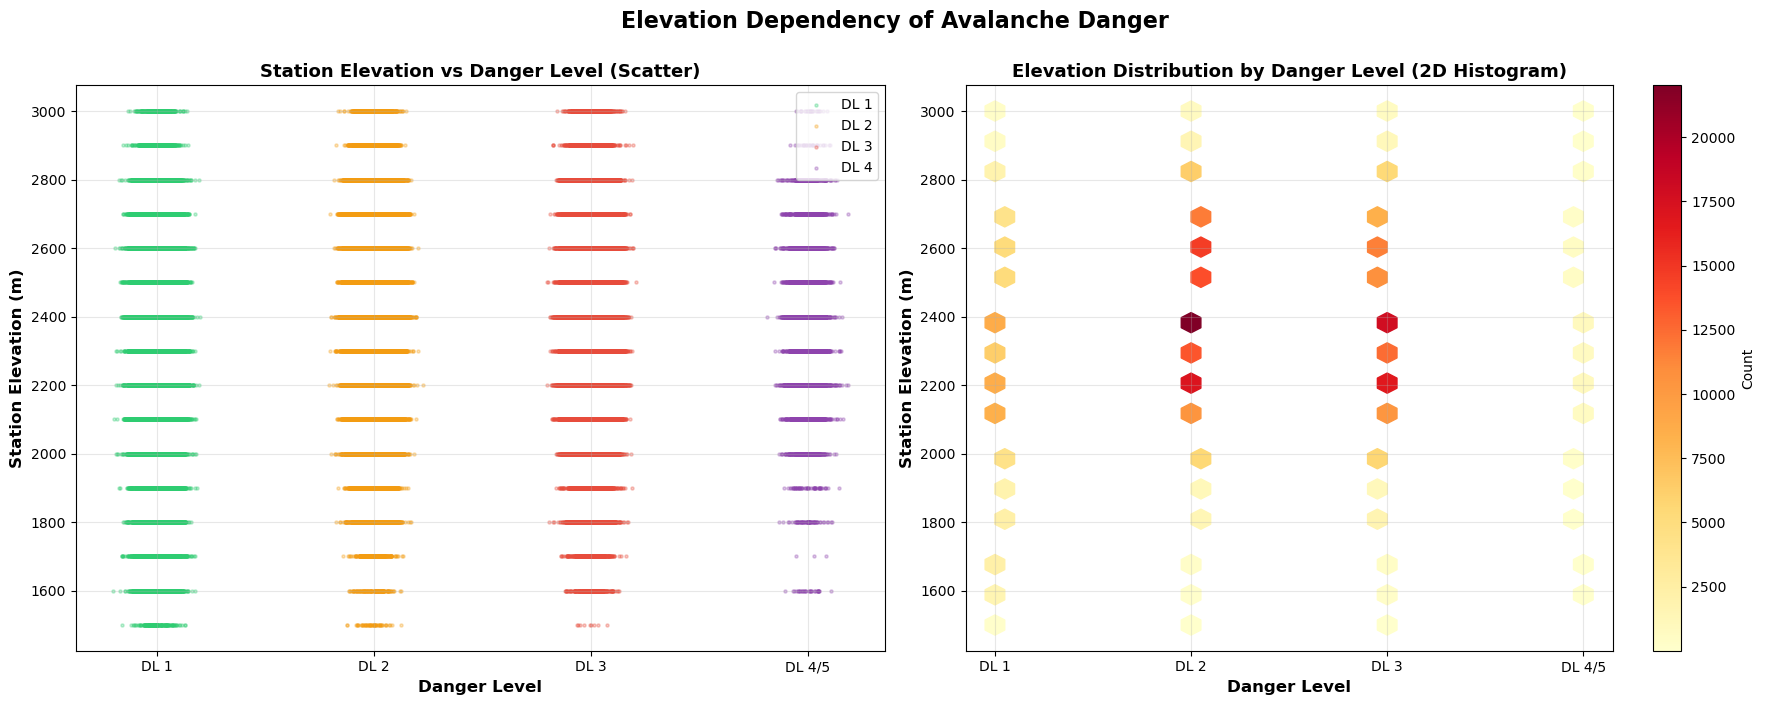


ELEVATION DEPENDENCY ANALYSIS

Mean Elevation by Danger Level:
--------------------------------------------------------------------------------
               mean     50%         std     min     max
DL 1    2270.502746  2300.0  300.228291  1500.0  3000.0
DL 2    2397.407958  2400.0  243.519072  1500.0  3000.0
DL 3    2370.533558  2400.0  249.055341  1500.0  3000.0
DL 4/5  2349.941815  2300.0  239.191162  1600.0  3000.0

INTERPRETATION:
✓ Higher danger levels should be associated with higher elevations
✓ DL 4/5 events predominantly occur at high-elevation stations
✓ This validates elevation as a key spatial feature for the CNN



In [16]:
# 2.3 Spatial Dependencies & Patterns
# This section proves that spatial context matters for avalanche danger prediction

# 1. Elevation Dependency Analysis
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Elevation Dependency of Avalanche Danger', 
             fontsize=16, fontweight='bold', y=1.00)

# 1a. Scatter plot with jitter
ax1 = axes[0]
for dl in [1, 2, 3, 4]:
    dl_data = avalanche_season[avalanche_season['dangerLevel'] == dl]
    # Add jitter to x-axis for better visualization
    jitter = np.random.normal(0, 0.05, size=len(dl_data))
    ax1.scatter(dl_data['dangerLevel'] + jitter, 
                dl_data['elevation_station'],
                alpha=0.3, s=5, 
                label=f'DL {dl}',
                color=['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad'][dl-1])

ax1.set_xlabel('Danger Level', fontsize=12, fontweight='bold')
ax1.set_ylabel('Station Elevation (m)', fontsize=12, fontweight='bold')
ax1.set_title('Station Elevation vs Danger Level (Scatter)', fontsize=13, fontweight='bold')
ax1.set_xticks([1, 2, 3, 4])
ax1.set_xticklabels(['DL 1', 'DL 2', 'DL 3', 'DL 4/5'])
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right')

# 1b. 2D Histogram (Hexbin)
ax2 = axes[1]
hexbin = ax2.hexbin(avalanche_season['dangerLevel'], 
                     avalanche_season['elevation_station'],
                     gridsize=30, cmap='YlOrRd', mincnt=1)
ax2.set_xlabel('Danger Level', fontsize=12, fontweight='bold')
ax2.set_ylabel('Station Elevation (m)', fontsize=12, fontweight='bold')
ax2.set_title('Elevation Distribution by Danger Level (2D Histogram)', 
              fontsize=13, fontweight='bold')
ax2.set_xticks([1, 2, 3, 4])
ax2.set_xticklabels(['DL 1', 'DL 2', 'DL 3', 'DL 4/5'])
ax2.grid(True, alpha=0.3)
plt.colorbar(hexbin, ax=ax2, label='Count')

plt.tight_layout()
plt.show()

# Print elevation statistics by danger level
print("\n" + "="*80)
print("ELEVATION DEPENDENCY ANALYSIS")
print("="*80)
print("\nMean Elevation by Danger Level:")
print("-" * 80)

elev_stats = avalanche_season.groupby('dangerLevel')['elevation_station'].describe()[['mean', '50%', 'std', 'min', 'max']]
elev_stats.index = ['DL 1', 'DL 2', 'DL 3', 'DL 4/5']
print(elev_stats.to_string())

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
print("✓ Higher danger levels should be associated with higher elevations")
print("✓ DL 4/5 events predominantly occur at high-elevation stations")
print("✓ This validates elevation as a key spatial feature for the CNN")
print("="*80 + "\n")

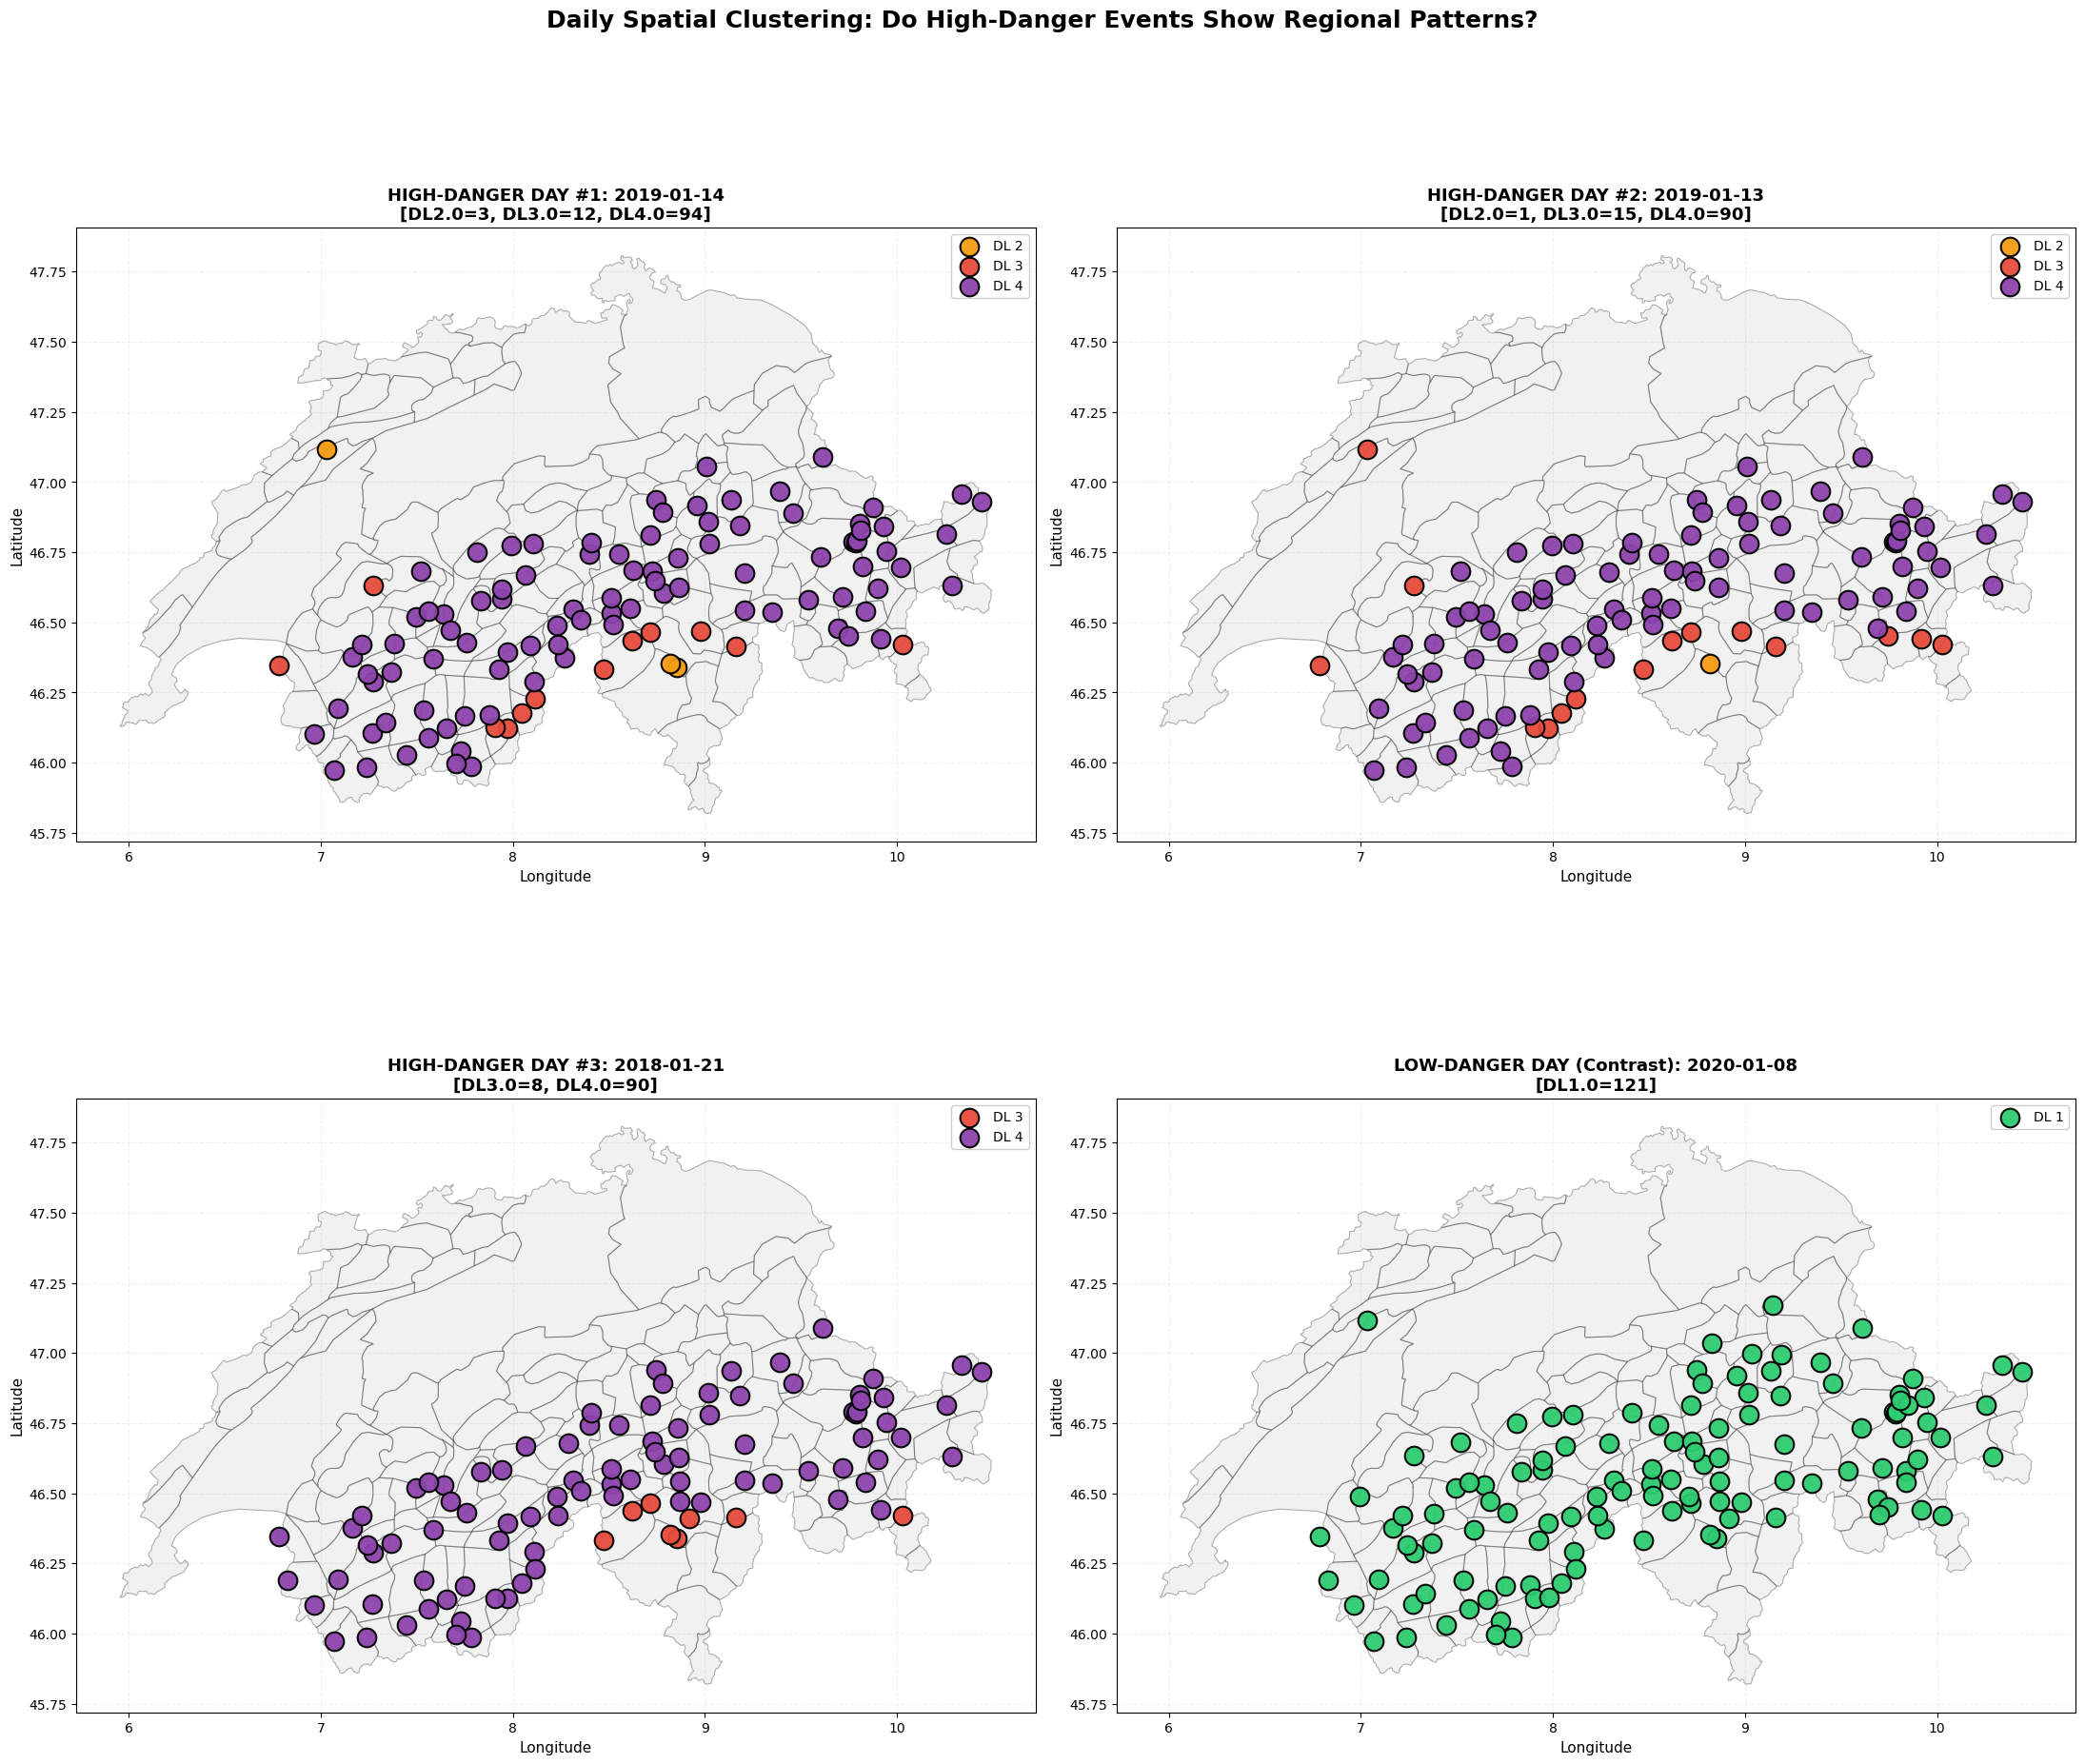


DAILY SPATIAL CLUSTERING VALIDATION

CNN Value Proposition: Spatial patterns must be present at daily resolution
--------------------------------------------------------------------------------

High-Danger Day #1: 2019-01-14
--------------------------------------------------------------------------------
  • DL 4:  94 stations ( 86.2%)
  • DL 3:  12 stations ( 11.0%)
  • DL 2:   3 stations (  2.8%)
  • DL 1:   0 stations (  0.0%)

  Regional DL4 Clustering:
    → Region 20.0: 94 DL4 stations

High-Danger Day #2: 2019-01-13
--------------------------------------------------------------------------------
  • DL 4:  90 stations ( 84.9%)
  • DL 3:  15 stations ( 14.2%)
  • DL 2:   1 stations (  0.9%)
  • DL 1:   0 stations (  0.0%)

  Regional DL4 Clustering:
    → Region 20.0: 90 DL4 stations

High-Danger Day #3: 2018-01-21
--------------------------------------------------------------------------------
  • DL 4:  90 stations ( 91.8%)
  • DL 3:   8 stations (  8.2%)
  • DL 2:   0 statio

In [17]:
# 2. Daily Spatial Clustering: High-Danger Day Snapshots
# Find multiple high-danger dates for comparison
dl4_dates = avalanche_season[avalanche_season['dangerLevel'] == 4]['datum'].value_counts()

if len(dl4_dates) > 0:
    # Select top 3 dates with most DL4 observations
    top_danger_dates = dl4_dates.head(3).index.tolist()
    
    # Also get a contrasting low-danger day
    dl1_dates = avalanche_season[avalanche_season['dangerLevel'] == 1]['datum'].value_counts()
    low_danger_date = dl1_dates.head(1).index[0] if len(dl1_dates) > 0 else None
    
    # Create comparison plot (3 high-danger days + 1 low-danger day)
    n_plots = 4 if low_danger_date is not None else 3
    fig, axes = plt.subplots(2, 2, figsize=(22, 20))
    axes = axes.flatten()
    
    fig.suptitle('Daily Spatial Clustering: Do High-Danger Events Show Regional Patterns?', 
                 fontsize=18, fontweight='bold', y=0.995)
    
    colors_map = {1: '#2ecc71', 2: '#f39c12', 3: '#e74c3c', 4: '#8e44ad'}
    
    # Plot high-danger days
    for idx, danger_date in enumerate(top_danger_dates):
        ax = axes[idx]
        day_data = avalanche_season[avalanche_season['datum'] == danger_date].copy()
        
        # Plot base map
        slf_bounds.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.8, alpha=0.3)
        
        # Plot stations by danger level (in order 1,2,3,4 so DL4 appears on top)
        for dl in [1, 2, 3, 4]:
            dl_subset = day_data[day_data['dangerLevel'] == dl]
            if len(dl_subset) > 0:
                ax.scatter(dl_subset['lon'], dl_subset['lat'],
                          c=colors_map[dl], s=200, 
                          edgecolor='black', linewidth=1.5, alpha=0.95,
                          label=f'DL {dl}', zorder=5)
        
        # Count stations by danger level
        dl_counts = day_data['dangerLevel'].value_counts().sort_index()
        count_str = ", ".join([f"DL{dl}={count}" for dl, count in dl_counts.items()])
        
        ax.set_title(f'HIGH-DANGER DAY #{idx+1}: {danger_date.strftime("%Y-%m-%d")}\n'
                     f'[{count_str}]',
                     fontsize=13, fontweight='bold')
        ax.set_xlabel('Longitude', fontsize=11)
        ax.set_ylabel('Latitude', fontsize=11)
        ax.legend(loc='upper right', fontsize=10, framealpha=0.95)
        ax.grid(True, alpha=0.2, linestyle='--')
    
    # Plot low-danger day for contrast
    if low_danger_date is not None:
        ax = axes[3]
        day_data = avalanche_season[avalanche_season['datum'] == low_danger_date].copy()
        
        slf_bounds.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.8, alpha=0.3)
        
        for dl in [1, 2, 3, 4]:
            dl_subset = day_data[day_data['dangerLevel'] == dl]
            if len(dl_subset) > 0:
                ax.scatter(dl_subset['lon'], dl_subset['lat'],
                          c=colors_map[dl], s=200,
                          edgecolor='black', linewidth=1.5, alpha=0.95,
                          label=f'DL {dl}', zorder=5)
        
        dl_counts = day_data['dangerLevel'].value_counts().sort_index()
        count_str = ", ".join([f"DL{dl}={count}" for dl, count in dl_counts.items()])
        
        ax.set_title(f'LOW-DANGER DAY (Contrast): {low_danger_date.strftime("%Y-%m-%d")}\n'
                     f'[{count_str}]',
                     fontsize=13, fontweight='bold')
        ax.set_xlabel('Longitude', fontsize=11)
        ax.set_ylabel('Latitude', fontsize=11)
        ax.legend(loc='upper right', fontsize=10, framealpha=0.95)
        ax.grid(True, alpha=0.2, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("\n" + "="*80)
    print("DAILY SPATIAL CLUSTERING VALIDATION")
    print("="*80)
    print("\nCNN Value Proposition: Spatial patterns must be present at daily resolution")
    print("-" * 80)
    
    for idx, danger_date in enumerate(top_danger_dates):
        day_data = avalanche_season[avalanche_season['datum'] == danger_date].copy()
        print(f"\nHigh-Danger Day #{idx+1}: {danger_date.strftime('%Y-%m-%d')}")
        print("-" * 80)
        
        for dl in [4, 3, 2, 1]:
            count = (day_data['dangerLevel'] == dl).sum()
            pct = count / len(day_data) * 100
            print(f"  • DL {dl}: {count:>3} stations ({pct:5.1f}%)")
        
        # Check spatial clustering by region
        if 'warnreg' in day_data.columns:
            regional_dl4 = day_data[day_data['dangerLevel'] == 4].groupby('warnreg').size()
            if len(regional_dl4) > 0:
                print(f"\n  Regional DL4 Clustering:")
                for region, count in regional_dl4.sort_values(ascending=False).head(3).items():
                    print(f"    → Region {region}: {count} DL4 stations")
    
    if low_danger_date is not None:
        day_data = avalanche_season[avalanche_season['datum'] == low_danger_date].copy()
        print(f"\nLow-Danger Day (Contrast): {low_danger_date.strftime('%Y-%m-%d')}")
        print("-" * 80)
        for dl in [1, 2, 3, 4]:
            count = (day_data['dangerLevel'] == dl).sum()
            pct = count / len(day_data) * 100
            print(f"  • DL {dl}: {count:>3} stations ({pct:5.1f}%)")
    
    print("\n" + "="*80)
    print("CNN JUSTIFICATION:")
    print("="*80)
    print("✓ If DL4 stations cluster in contiguous regions → CNN can learn spatial patterns")
    print("✓ If DL4 appears as scattered 'salt-and-pepper' noise → CNN has no advantage")
    print("✓ Visual inspection: Do you see regional clusters (e.g., all of Valais red)?")
    print("="*80 + "\n")
    
else:
    print("⚠️ No DL4 observations found in the dataset.")

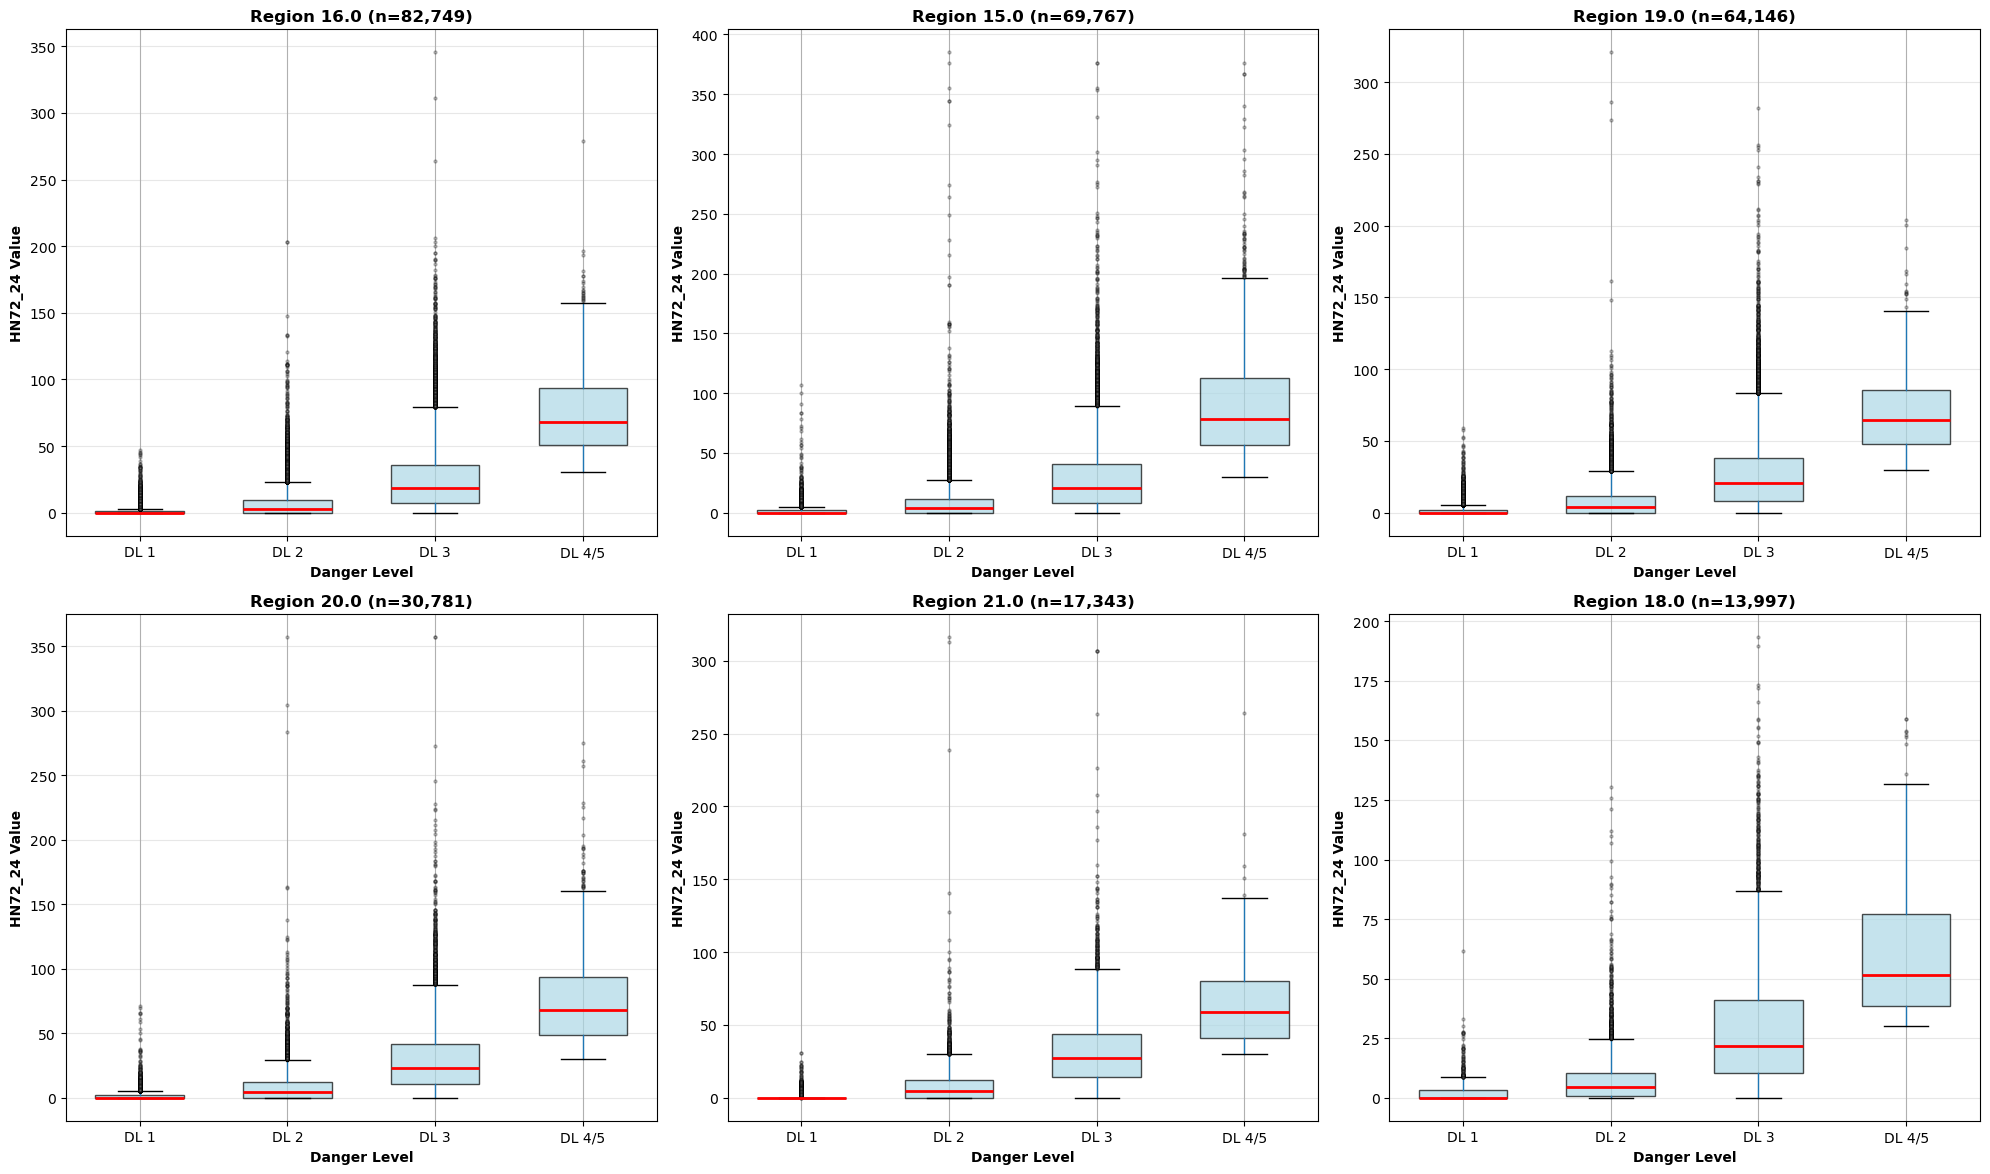

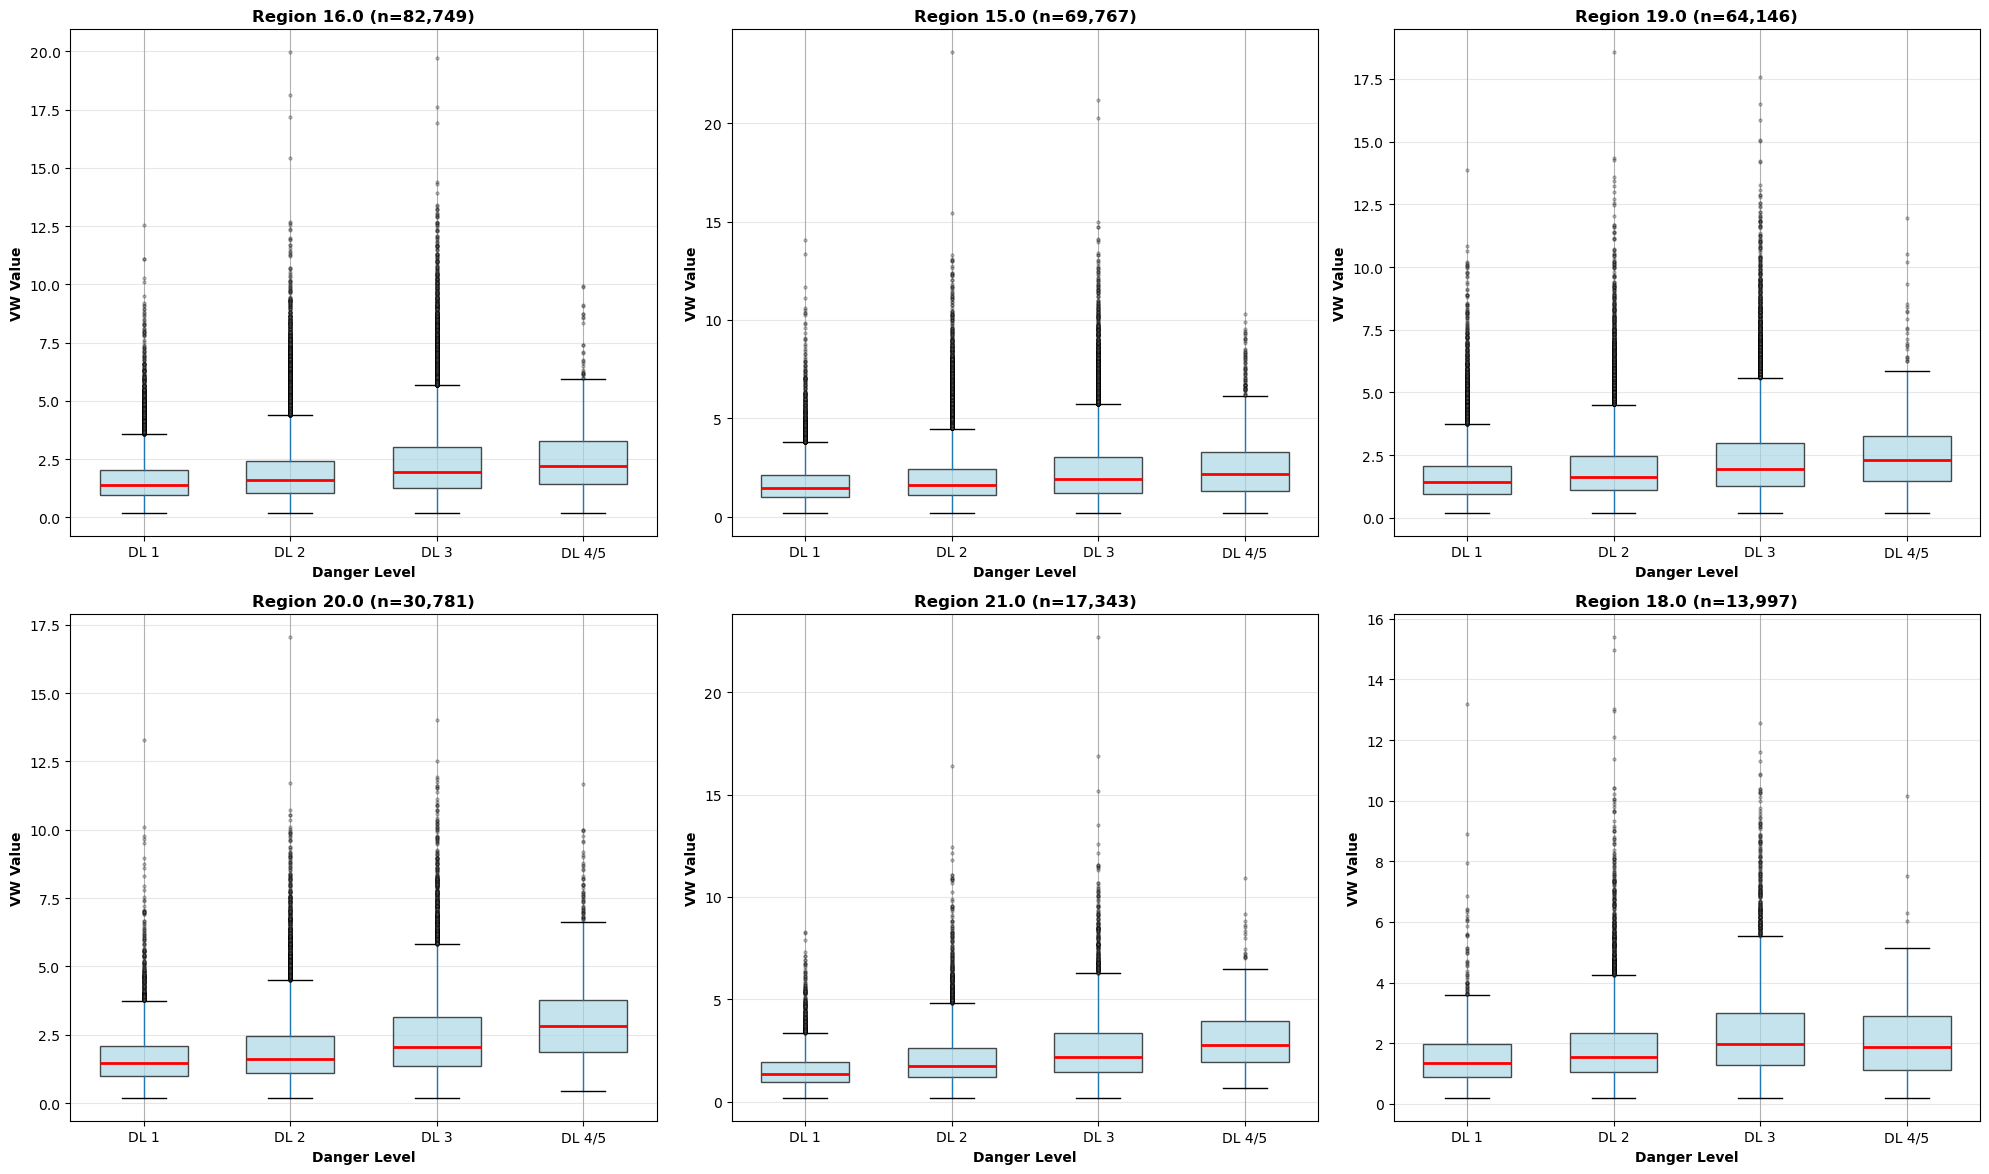

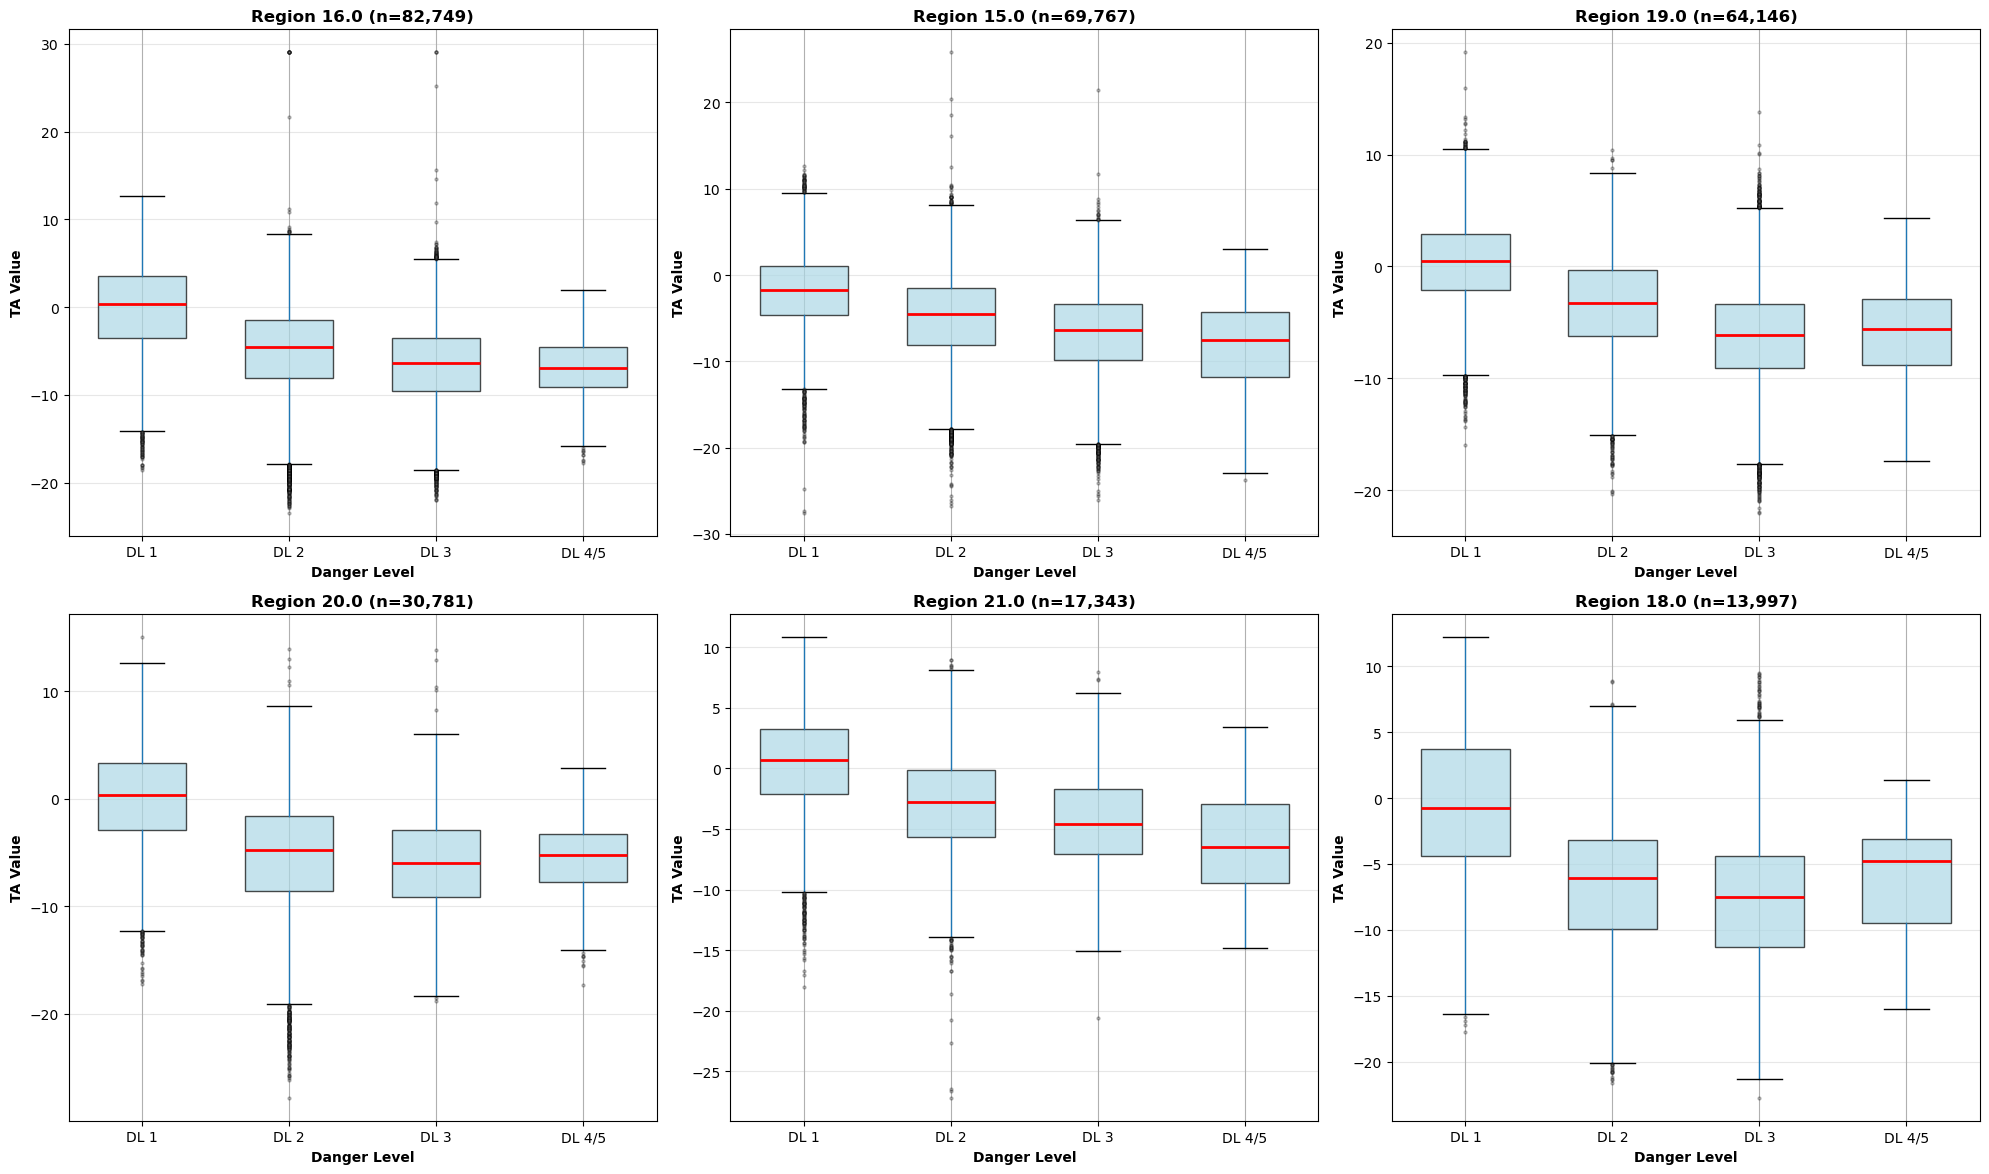

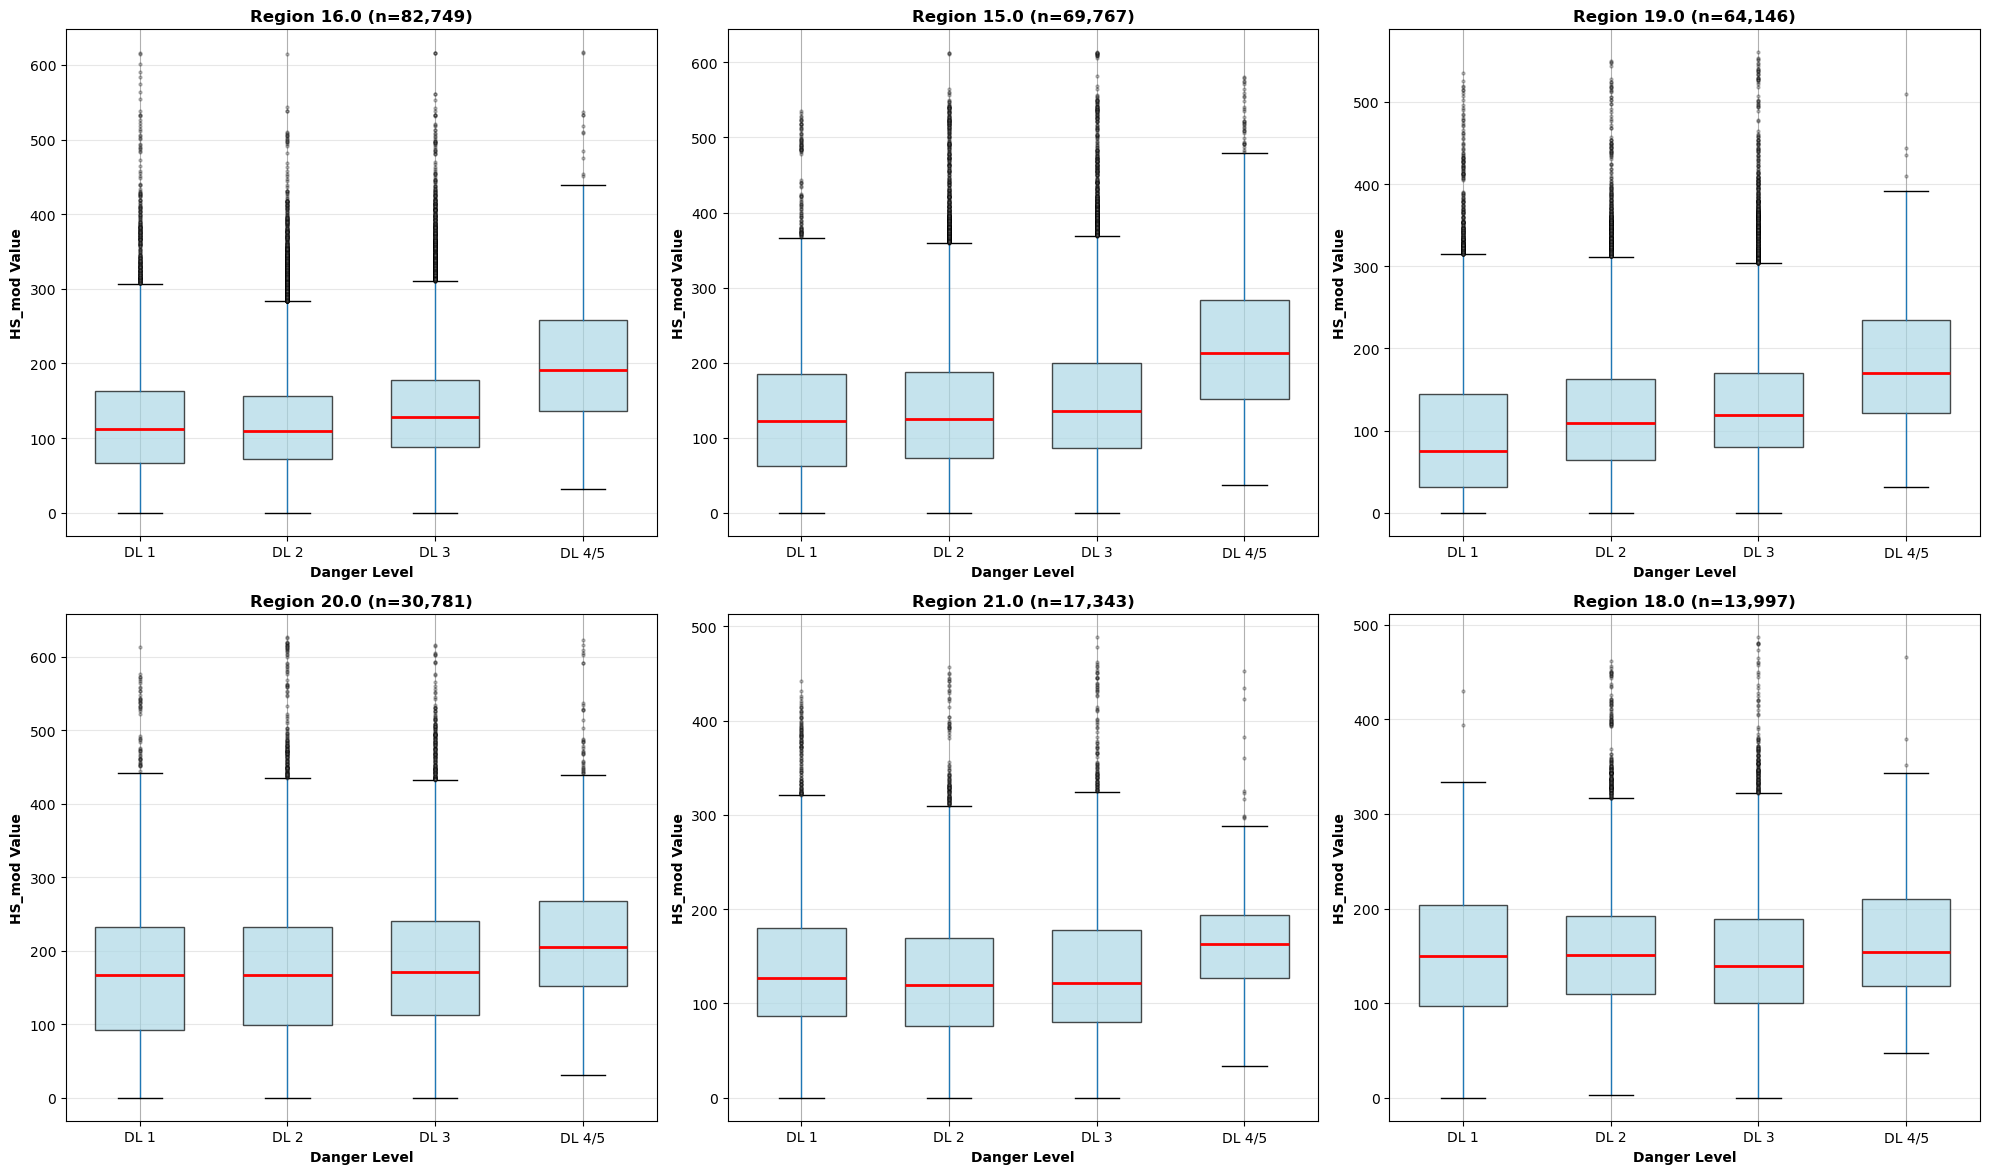


REGIONAL DRIVER ANALYSIS: Are Avalanche Rules Region-Specific?

HN72_24: Mean Values by Region and Danger Level
--------------------------------------------------------------------------------
                  DL1       DL2        DL3        DL4
region_name                                          
Region 15.0  1.689958  8.078744  28.487570  89.858896
Region 16.0  1.271267  6.622023  25.442366  74.950752
Region 18.0  2.777361  7.454459  29.371655  62.084772
Region 19.0  1.843066  8.039036  27.211753  69.771141
Region 20.0  1.913734  8.291360  30.254187  75.584287
Region 21.0  0.741104  8.278505  31.941518  66.236649

Regional Variability for High Danger (DL 4):
--------------------------------------------------------------------------------
  Region 15.0:    89.86
  Region 20.0:    75.58
  Region 16.0:    74.95
  Region 19.0:    69.77
  Region 21.0:    66.24
  Region 18.0:    62.08

  Coefficient of Variation: 13.3%
  ✓ LOW variability → Suggests uniform drivers across regions

VW: M

In [18]:
# 3. Regional Driver Analysis: Are Physical Rules Different by Region?
# Define major regions (you can adjust these based on your warnreg codes)
if 'warnreg' in avalanche_season.columns:
    
    # Get unique regions and select top ones by observation count
    region_counts = avalanche_season['warnreg'].value_counts()
    top_regions = region_counts.head(6).index.tolist()  # Analyze top 6 regions
    
    # Filter to only these regions
    regional_data = avalanche_season[avalanche_season['warnreg'].isin(top_regions)].copy()
    
    # Create region labels (you can customize these based on actual region names)
    region_labels = {
        reg: f"Region {reg}" for reg in top_regions
    }
    regional_data['region_name'] = regional_data['warnreg'].map(region_labels)
    
    # Key meteorological drivers to compare
    key_drivers = ['HN72_24', 'VW', 'TA', 'HS_mod']
    available_drivers = [d for d in key_drivers if d in regional_data.columns]
    
    if len(available_drivers) > 0:
        # Create faceted plots for each driver
        for driver in available_drivers:
            fig, axes = plt.subplots(2, 3, figsize=(20, 12))
            axes = axes.flatten()
            fig.suptitle(f'{driver} by Danger Level: Regional Comparison', 
                         fontsize=16, fontweight='bold', y=0.995)
            
            for idx, region in enumerate(top_regions):
                ax = axes[idx]
                region_subset = regional_data[regional_data['warnreg'] == region]
                
                # Create boxplot
                region_subset.boxplot(column=driver, by='dangerLevel', ax=ax,
                                      patch_artist=True, widths=0.6,
                                      boxprops=dict(facecolor='lightblue', alpha=0.7),
                                      medianprops=dict(color='red', linewidth=2),
                                      flierprops=dict(marker='o', markerfacecolor='gray', 
                                                    markersize=2, alpha=0.3))
                
                ax.set_title(f'{region_labels[region]} (n={len(region_subset):,})', 
                            fontsize=12, fontweight='bold')
                ax.set_xlabel('Danger Level', fontsize=10, fontweight='bold')
                ax.set_ylabel(f'{driver} Value', fontsize=10, fontweight='bold')
                ax.set_xticklabels(['DL 1', 'DL 2', 'DL 3', 'DL 4/5'])
                ax.grid(axis='y', alpha=0.3)
                plt.suptitle('')
            
            plt.tight_layout()
            plt.show()
        
        # Print statistical comparison
        print("\n" + "="*80)
        print("REGIONAL DRIVER ANALYSIS: Are Avalanche Rules Region-Specific?")
        print("="*80)
        
        for driver in available_drivers:
            print(f"\n{driver}: Mean Values by Region and Danger Level")
            print("-" * 80)
            
            # Create pivot table: regions vs danger levels
            pivot_data = regional_data.groupby(['region_name', 'dangerLevel'])[driver].mean().unstack()
            pivot_data.columns = [f'DL{int(col)}' for col in pivot_data.columns]
            
            print(pivot_data.to_string())
            
            # Calculate regional variability
            print(f"\nRegional Variability for High Danger (DL 4):")
            print("-" * 80)
            dl4_means = regional_data[regional_data['dangerLevel'] == 4].groupby('region_name')[driver].mean()
            for region, mean_val in dl4_means.sort_values(ascending=False).items():
                print(f"  {region}: {mean_val:>8.2f}")
            
            std_across_regions = dl4_means.std()
            mean_across_regions = dl4_means.mean()
            cv = (std_across_regions / mean_across_regions) * 100 if mean_across_regions != 0 else 0
            
            print(f"\n  Coefficient of Variation: {cv:.1f}%")
            if cv > 30:
                print(f"  ⚠️ HIGH variability → Suggests region-specific avalanche drivers")
            else:
                print(f"  ✓ LOW variability → Suggests uniform drivers across regions")
        
        print("\n" + "="*80)
        print("CNN ADVANTAGE OVER RANDOM FOREST:")
        print("="*80)
        print("✓ If drivers vary by region → CNN can learn spatially-dependent rules")
        print("✓ If drivers are uniform → Simple RF may be sufficient")
        print("✓ High coefficient of variation (CV > 30%) justifies spatial modeling")
        print("="*80 + "\n")
    
    else:
        print("⚠️ No key meteorological drivers found in the dataset.")
        print(f"Expected: {key_drivers}")
        
else:
    print("⚠️ Warning: 'warnreg' (region) column not found in the dataset.")
    print("Regional analysis requires station-to-region mapping.")

### **2.4 Seasonal Trends and Autocorrelation**

Avalanche danger is path-dependent; it depends on what happened yesterday and last week.

Time Series visualization: Plot dangerLevel, HN24 (daily snow), and HS_mod (total snow) together for one major station (e.g., Weissfluhjoch WFJ2) over one full winter season.

Goal: See if spikes in HN24 immediately precede spikes in dangerLevel.

Persistence check: What is the probability that today's danger level is the same as yesterday's?

Why? A "naive" model that just predicts yesterday's value is surprisingly hard to beat. You need to know this baseline accuracy.

### **2.5 Multicollinearity Analysis**